In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [28]:
from time import time
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

# enable 16 bit precision for jax                                                                                                                             
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit, grad, random

import numpyro
import numpyro.distributions as dist
MultivariateNormal = dist.MultivariateNormal
from numpyro.distributions import Normal
import optax

# Import GSM                                                                                                                                                  
import sys
sys.path.append('../gsmvi//')
from gsm import GSM
from bbvi import ADVI, Scorenorm, Fishernorm
#####                                                                                                                                                         
from initializers import lbfgs_init

# sys.path.append('../utils/')
# from monitors import KLMonitor_Gauss as Monitor

import tensorflow_probability as tfp
# SinhArcsinh = tfp.substrates.jax.distributions.SinhArcsinh
# MultivariateNormal_tf = tfp.substrates.jax.distributions.MultivariateNormalFullCovariance

from IPython.display import Image, display

In [29]:
from gsmvi.monitors import KLMonitor as Monitor


# Fit Gaussian

In [30]:
@jit
def em_exact(llambda, psi, mu, cov):
    r = llambda.shape[1]
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    alpha = llambda.T@psi_inv    
    beta = jnp.linalg.pinv(np.identity(r) + alpha@llambda)

    gamma = cov@(alpha.T@beta.T)
    llambda_update = gamma @ jnp.linalg.pinv(beta + beta@alpha@gamma) 
    
    A = jnp.eye(D) - llambda_update @beta @ llambda.T @psi_inv
    M = A@cov@A.T + llambda_update @beta @llambda_update.T
    psi_update = jnp.diag(jnp.diagonal(M))
    
    return llambda_update, psi_update



def lower_bound_kl(cov, psi, llambda):
    A = psi + llambda@llambda.T #+ 1e-6*np.eye(psi.size)
    logabsdet = np.linalg.slogdet(A)
    # assert logabsdet.sign == 1.0    
    kl = np.trace(cov@np.linalg.pinv(A)) + logabsdet.logabsdet
    # print(np.trace(cov@np.linalg.pinv(A)), np.log((np.linalg.det(A))), np.linalg.det(A))
    return kl


#using mle for training
def fit_lr_gaussian2(data, mu, cov, num_of_latents, eta=1.0,
                tolerance=0.001,num_of_itr=100, diagnosis=False, 
                llambda=None, psi=None):
        

    D = mu.size
    K = num_of_latents
    if llambda is None:
        llambda = np.random.normal(0, 1, size=(D, K))*0.1
    if psi is None:
        psi = np.diag(np.random.random(D))


    #cap the maximum number of iterations
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0
    losses = []
    psis, llambdas = [], []
    
    while counter < num_of_itr:

        llambda_update, psi_update = em_exact(llambda, psi, mu, cov)
        psi = (1 - eta)*psi + eta*psi_update
        llamdba = (1 - eta)*llambda  + eta*llambda_update
        #use lower bound to determine if convergeda
        lower_bound_old=lower_bound
        # lower_bound=get_lower_bound(data, mu, llambda, psi)
        lower_bound=lower_bound_kl(cov, psi, llambda)
            
        if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
            return mu, llambda, psi, [psis, llambdas, losses]
        llambdas.append(llambda)
        psis.append(np.diag(psi))
        losses.append(lower_bound)
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return mu, llambda, psi, [psis, llambdas, losses]


# Factorize BAM

In [59]:
import jax
import jax.numpy as jnp
from jax import jit, random
import numpy as np
import numpyro.distributions as dist


def fg_bam_update(lp, lp_g, samples, mu0, S0, reg):
    """
    Returns updated mean and diagonal covariance matrix with factorized BaM updates.
    """
    B = samples.shape[0]

    zbar = jnp.mean(samples, axis=0)
    C = jnp.var(samples, axis=0)

    g = lp_g(samples)

    gbar = jnp.mean(g, axis=0)
    Gamma = jnp.var(g, axis=0)

    a = Gamma + jnp.square(gbar) / (1 + reg)
    b = 1 / reg
    c = -  (C + S0 / reg + jnp.square(mu0 - zbar) / (1 + reg))

    # print("gbar:", gbar)
    # print("Gamma:", Gamma)
    # print("a:", a)
    # print("b: ", b)
    # print("c:", c)

    S_1 = (-b + jnp.sqrt(jnp.square(b) - 4 * jnp.multiply(a, c))) / (2 * a)
    S_2 = (-b - jnp.sqrt(jnp.square(b) - 4 * jnp.multiply(a, c))) / (2 * a)
    S = jnp.maximum(S_1, S_2)

    mu = (zbar + jnp.multiply(S, gbar)) * reg + mu0
    mu = mu / (1 + reg)

    return mu, S
    

class FG_BAM:
    """
    Wrapper class for using factorized BaM updates to fit a distribution.
    """
    def __init__(self, D, lp, lp_g):
        """
        Inputs:
          D: (int) Dimensionality (number) of parameters
          lp : Function to evaluate target log-probability distribution. 
               (Only used in monitor, not for fitting)
          lp_g : Function to evaluate score, i.e. the gradient of the target log-probability distribution
        """
        self.D = D
        self.lp = lp
        self.lp_g = lp_g
    
    def fit(self, key, regf, mean=None, cov_diag=None, batch_size=2, niter=5000, nprint=10, jitter=1e-6):
        """
        Main function to fit a factorized Gaussian distribution to the target.
        """
        if mean is None:
            mean = jnp.zeros(self.D)
        if cov_diag is None:
            cov_diag = jnp.ones(self.D)
        
        # params = (mean, cov_diag)
        # nevals = 1
        mean_all = np.empty((niter, self.D))
        cov_all = np.empty((niter, self.D))

        if nprint > niter: nprint = niter
        for i in range(niter):
            if (i%(niter//nprint) == 0): print(f'Iteration {i} of {niter}')
            mean_all[i, :] = mean
            cov_all[i, :] = cov_diag

            key, _ = random.split(key)        
            eps = dist.Normal(0, 1).expand([self.D]).sample(key, (batch_size, ))
            samples = mean + eps * jnp.sqrt(cov_diag)

            # if i == 0 : reg = regf(i)
            reg = regf(i)
            reg = max(reg, 1e-5)

            mean_new, cov_new = fg_bam_update(self.lp, self.lp_g, samples, mean, cov_diag, reg)

            cov_new += np.ones(self.D) * jitter
            # cov_new = (cov_new + cov_new) / 2  # symmetrize

            mean, cov_diag = mean_new, cov_new
        
        return mean, cov_diag, mean_all, cov_all






# BAM, BAM_lr

In [60]:
from bam import BAM
from gsm import GSM
from pbam import PBAM, PBAM_fullcov
from pgsm import PGSM
from gsmvi.monitors import KLMonitor
# from gsmvi.bam_lrproject import BAM_lrproject



In [61]:

#### Simple experiment for multivaraite Gaussian with dense covariance matrix
####                                                                                                                                                         
def setup_model(D=10, rank=4, seed=123):

    # setup a Gaussian target distribution                                                                                                                    
    np.random.seed(seed)
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples

def setup_gauss_model(D, seed=123, noise=1e-2, mean=None, rank=None):
    np.random.seed(seed)
    if mean is None:
        mean = np.random.random(D)
    if rank is None:
        rank = D
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.eye(D)*noise
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 5000)
    return mean, cov, lp, lp_g, ref_samples

In [66]:

D = 64
rank = 32
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)
# mean, cov, lp, lp_g, ref_samples = setup_gauss_model(D, rank=rank)

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

batch_size = 2
niter = 1000
nprint = 10
regf = lambda x: 100/(1+x)


In [67]:
start = time()
# alg = GSM(D, lp_vmap, lp_g_vmap)
alg = BAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
batch_size = 2
niter = 100
regf = lambda x: 1000#/(1+x)

monitorbam = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=10)
# monitor = None
meanfit, covfit = alg.fit(key,  batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=monitorbam, check_goodness=False)
# meanfit, covfit = alg.fit(key,  batch_size=batch_size, niter=niter, nprint=nprint, monitor=monitorbam, check_goodness=False)
print(time()-start)

use low rank
Iteration 0 of 100
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100
Iteration 100 of 100
0.5697309970855713


In [68]:
start = time()
ranklr = rank

batch_size = 2
niter = 100
alg3 = PBAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
nprint = 10
regf = lambda x: 100
# regf = lambda x: 1/(1+x)
# regf = lambda x: 0.1#/(1+x)
# regf = lambda i :  0.1*i*(i<201) + (i>100)*10000/(1+i)
monitor3 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanfit3, psi, llambda = alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, 
                                  tolerance=1e-4, eta=1.0, niter_em=501, 
                                  print_convergence=False, monitor=monitor3)
# covfit3 = np.diag(psi) + llambda@llambda.T

print(time() - start)

Iteration 0 of 100. Time taken :  2.1457672119140625e-06
compiled
Iteration 10 of 100. Time taken :  0.09441161155700684
time for first 10 iterations :  0.09442591667175293
Iteration 20 of 100. Time taken :  0.21107816696166992
Iteration 30 of 100. Time taken :  0.2837405204772949
Iteration 40 of 100. Time taken :  0.3443760871887207
Iteration 50 of 100. Time taken :  0.4058849811553955
Iteration 60 of 100. Time taken :  0.47371578216552734
Iteration 70 of 100. Time taken :  0.5329165458679199
Iteration 80 of 100. Time taken :  0.5917961597442627
Iteration 90 of 100. Time taken :  0.6483478546142578
Iteration 100 of 100. Time taken :  0.7166743278503418
Total number of projections :  658 6.58
0.7925381660461426


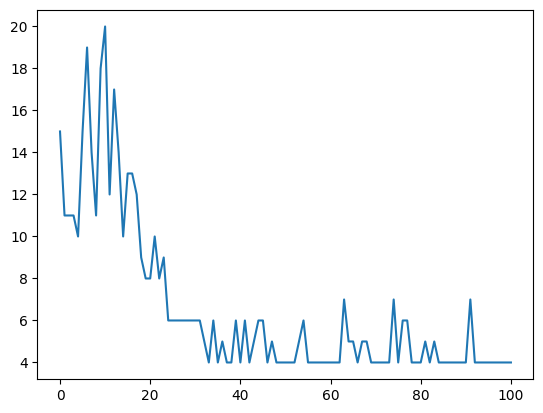

In [69]:
plt.plot(monitor3.nprojects)

In [70]:
np.sum(monitor3.nprojects)/niter

6.58

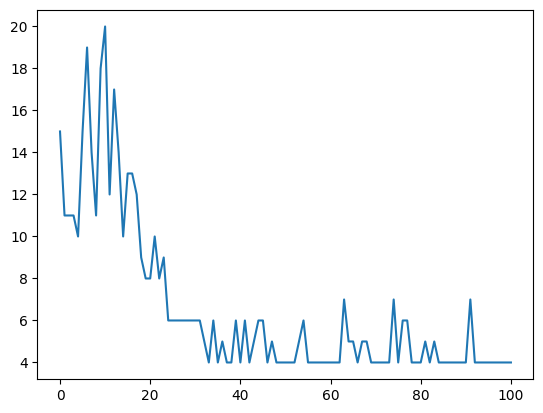

In [71]:
plt.plot(monitor3.nprojects[:])

[]

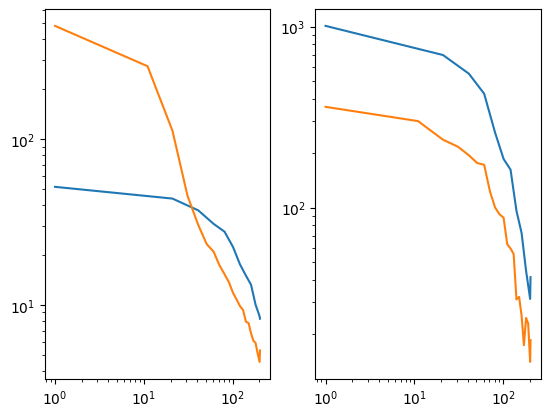

In [72]:
plt.subplot(121)
plt.plot(monitorbam.nevals, monitorbam.rkl)
plt.plot(monitor3.nevals, monitor3.rkl)
plt.loglog()
plt.subplot(122)
plt.plot(monitorbam.nevals, monitorbam.fkl)
plt.plot(monitor3.nevals, monitor3.fkl)
plt.loglog()

In [73]:
meanfit3;

50


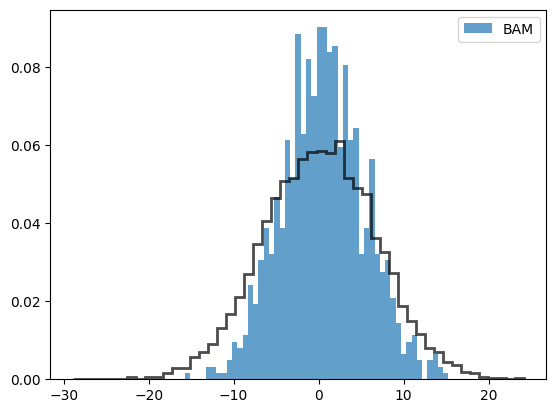

In [74]:
i = np.random.randint(D)
print(i)
plt.hist(np.random.multivariate_normal(meanfit, covfit, 1000)[..., i], bins=50, density=True, alpha=0.7, label='BAM');
# plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 10000)[..., i], bins=50, density=True, alpha=0.7, label='BAM_lr');
eps = np.random.normal(0, 1, (2000, D))
z = np.random.normal(0, 1, (2000, ranklr))
s3 = meanfit3 + psi*eps + (llambda@z.T).T
# s3 = np.random.multivariate_normal(meanfit3, covfit3, 5000)
# s3 = np.random.multivariate_normal(meanfit3[0], covfit3, 5000)
# plt.hist(s3[..., i], bins=50, density=True, alpha=0.7, label='BAM_lr2');
plt.hist(ref_samples[..., i], bins=50, density=True, alpha=0.7, histtype='step', lw=2, color='k');
plt.legend()



[47 30 27  2 42]


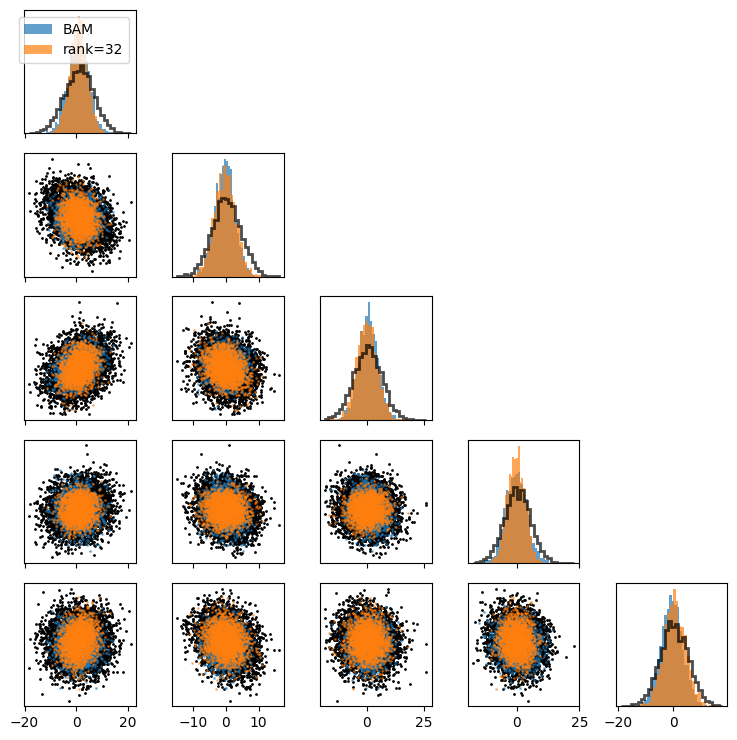

In [75]:
s = ref_samples[:5000, :] 
s1 = np.random.multivariate_normal(meanfit, covfit, 2000)
# s1 = None
# s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
s2 = None
# s3 = np.random.multivariate_normal(meanfit3, covfit3, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            if s1 is not None: ax[i, i].hist(s1[..., ii], alpha=0.7, density=True, bins=30, label=f"BAM");
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            if s2 is not None: ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}-fullcov");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            if s1 is not None: ax[j, i].plot(s1[..., ii], s1[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            if s2 is not None: ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()



# Mean field GSM

In [76]:
from gsmvi.gsm_mf import GSM_MF

alg_gsm_mf = GSM_MF(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
batch_size = 1
niter = 1000

monitorgsmmf = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=10)
# monitor = None
mean_gsmmf, cov_gsmmf = alg_gsm_mf.fit(key,  batch_size=batch_size, niter=niter, nprint=nprint, monitor=monitorgsmmf, check_goodness=True)


Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Iteration 1000 of 1000


[]

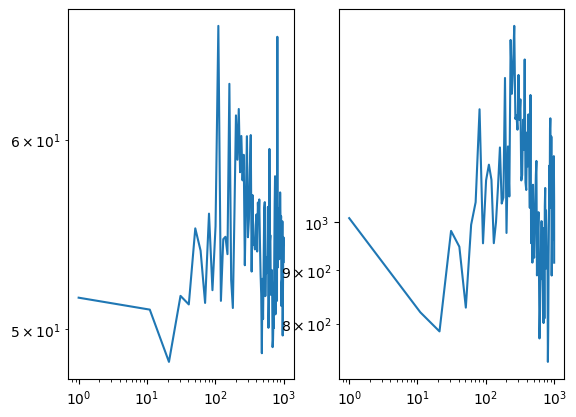

In [77]:
plt.subplot(121)
plt.plot(monitorgsmmf.nevals, monitorgsmmf.rkl)
plt.loglog()
plt.subplot(122)
plt.plot(monitorgsmmf.nevals, monitorgsmmf.fkl)
plt.loglog()

[51 60 31 25 21]


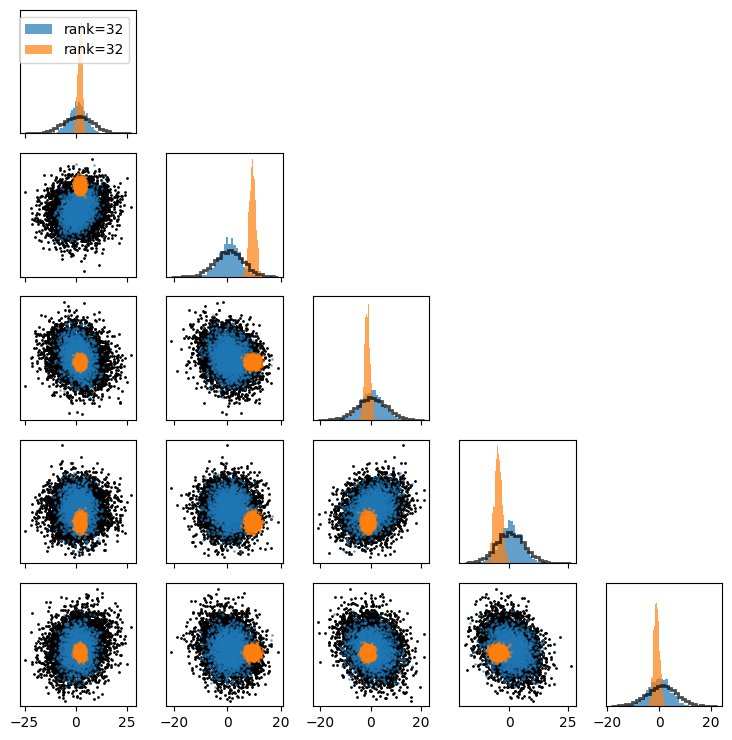

In [78]:
s = ref_samples[:5000, :] 
s_gsmmf = np.random.multivariate_normal(mean_gsmmf, np.diag(cov_gsmmf), 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            ax[i, i].hist(s_gsmmf[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_gsmmf[..., ii], s_gsmmf[..., jj], '.', alpha=0.5, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()



# factorized BAM


In [79]:

alg_bam_mf = FG_BAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
batch_size = 2
niter = 5000
regf = lambda x: 100/(1+x)

monitorbammf = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=10)
# monitor = None
mean_bammf, cov_bammf, _, _ = alg_bam_mf.fit(key,  regf, batch_size=batch_size, niter=niter, nprint=nprint, )


Iteration 0 of 5000
Iteration 500 of 5000
Iteration 1000 of 5000
Iteration 1500 of 5000
Iteration 2000 of 5000
Iteration 2500 of 5000
Iteration 3000 of 5000
Iteration 3500 of 5000
Iteration 4000 of 5000
Iteration 4500 of 5000


[53  0 59 62 63]


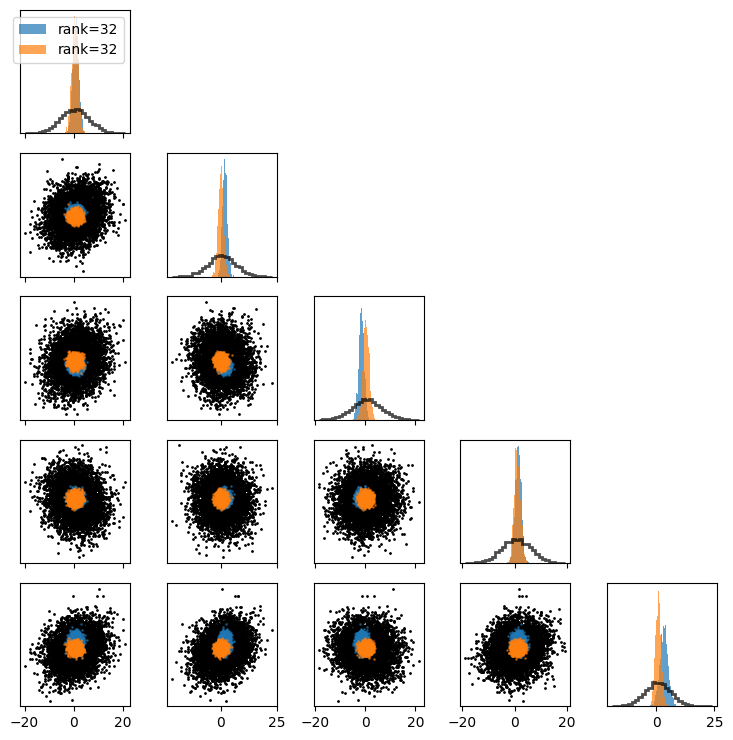

In [81]:
s = ref_samples[:5000, :] 
s_gsmmf = np.random.multivariate_normal(mean_gsmmf, np.diag(cov_gsmmf), 2000)
s_bammf = np.random.multivariate_normal(mean_bammf, np.diag(cov_bammf), 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            # ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            ax[i, i].hist(s_gsmmf[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            ax[i, i].hist(s_bammf[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            # ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_gsmmf[..., ii], s_gsmmf[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_bammf[..., ii], s_bammf[..., jj], '.', alpha=0.5, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()



# bfgs

In [82]:
from gsmvi.initializers import lbfgs_init

In [83]:
mean_bfgs, cov_bfgs, res = lbfgs_init(np.random.random(D), lp, lp_g)
print(res)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 121.47617318875791
        x: [ 6.985e-01  2.855e-01 ...  6.258e-01  6.768e-01]
      nit: 37
      jac: [ 6.686e-05 -6.662e-05 ... -1.498e-04  1.399e-04]
     nfev: 40
     njev: 40
 hess_inv: <64x64 LbfgsInvHessProduct with dtype=float64>


In [84]:
from scipy.optimize import minimize
f = lambda x: -lp(x)
if lp_g is not None:
    f_g = lambda x: -lp_g(x)
else:
    f_g = None
x0 = np.random.random(D)+10.
res = minimize(f, x0, method='L-BFGS-B', jac=f_g, \
               options={"maxiter":1000, "maxfun":1000, "maxcor":10, "ftol":1e-10, "gtol":1e-10, })
# res = minimize(f, x0, method='L-BFGS-B', jac=f_g, \
#                options={"maxiter":1000, "maxfun":1000, "maxcor":10})

mean_bfgs  = res.x
cov_bfgs = res.hess_inv.todense()
print(res)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 121.47617141983963
        x: [ 6.964e-01  2.858e-01 ...  6.253e-01  6.746e-01]
      nit: 73
      jac: [-7.151e-06 -7.042e-06 ...  4.122e-06  2.753e-06]
     nfev: 81
     njev: 81
 hess_inv: <64x64 LbfgsInvHessProduct with dtype=float64>


In [85]:
_, llambda_init, psi_init, _ = fit_lr_gaussian2(np.zeros(D), np.zeros(D), cov_bfgs, rank, tolerance=0., num_of_itr=500, diagnosis=True)
psi_init = np.diag(psi_init)
mean_init = mean_bfgs

500 iterations to reach convergence



In [86]:
# %timeit res.hess_inv(x0)
# %timeit (m@x0)

In [87]:
np.random.seed(90)
mean_init = jnp.zeros(D)
# llambda_init = np.random.normal(0, 1, size=(D, rank)) 
# psi_init = 1+np.random.random(D)
# llambda_init = np.random.normal(0, 0.1, size=(D, rank)) 
# psi_init = 0.1 + np.random.random(D)*0.01
eps = np.random.normal(0, 1, (2000, D))
z = np.random.normal(0, 1, (2000, ranklr))
s_init = mean_init + psi_init*eps + (llambda_init@z.T).T
s_init.shape

(2000, 64)

[38  1 37 26 55]


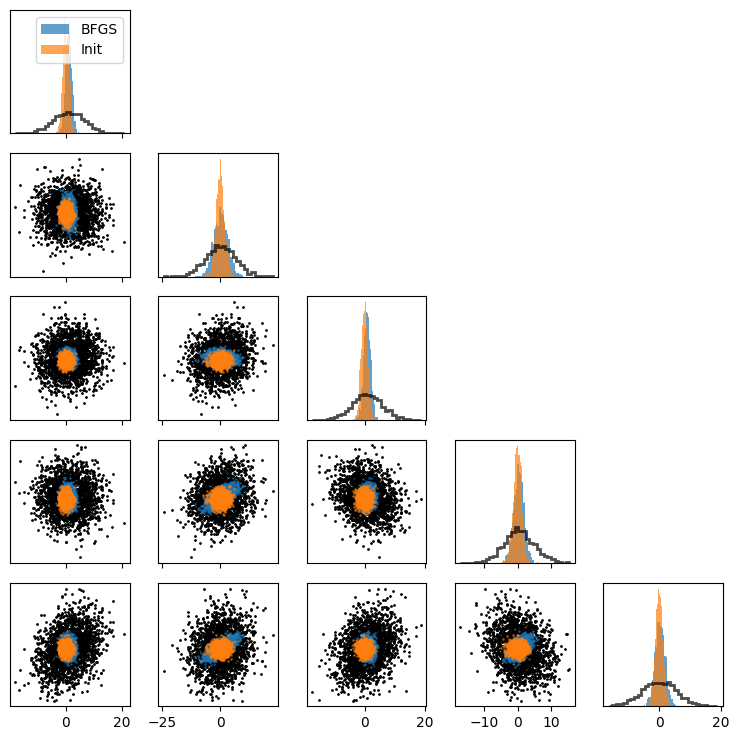

In [88]:
s = ref_samples[:2000, :] 
s_bfgs = np.random.multivariate_normal(mean_bfgs, cov_bfgs, 2000)
s_gsmmf = np.random.multivariate_normal(mean_gsmmf, np.diag(cov_gsmmf), 2000)
# s_bammf = np.random.multivariate_normal(mean_bammf, np.diag(cov_bammf), 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            # ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            # ax[i, i].hist(s_gsmmf[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            ax[i, i].hist(s_bfgs[..., ii], alpha=0.7, density=True, bins=30, label="BFGS");
            ax[i, i].hist(s_init[..., ii], alpha=0.7, density=True, bins=30, label="Init");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            # ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            # ax[j, i].plot(s_gsmmf[..., ii], s_gsmmf[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_bfgs[..., ii], s_bfgs[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_init[..., ii], s_init[..., jj], '.', alpha=0.5, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()


# PGSM

In [91]:
ranklr = rank
# alg2 = PBAM_fullcov(D, lp_vmap, lp_g_vmap)
# key = jax.random.PRNGKey(2)
# monitor2 = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
# meanfit2, covfit2 = alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=monitor, early_stop=False)

batch_size = 2
niter = 100
alg4 = PGSM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
nprint = 10
# regf = lambda x: 1/(1+x)
# regf = lambda x: 0.1#/(1+x)
# regf = lambda i :  0.1*i*(i<201) + (i>100)*10000/(1+i)
monitor2 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanpgsm, psipgsm, llambdapgsm = alg4.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, nprint=nprint, 
                                  tolerance=1e-4, eta=1., niter_em=501, gamma=0., scalellambda=0.1,
                                  print_convergence=False, monitor=monitor2)
# covfit3 = np.diag(psi) + llambda@llambda.T



Iteration 0 of 100. Time taken :  2.1457672119140625e-06
compiled
Iteration 10 of 100. Time taken :  0.12726068496704102
time for first 10 iterations :  0.1272749900817871
Iteration 20 of 100. Time taken :  0.3387892246246338
Iteration 30 of 100. Time taken :  0.5693292617797852
Iteration 40 of 100. Time taken :  0.8047440052032471
Iteration 50 of 100. Time taken :  1.048713207244873
Iteration 60 of 100. Time taken :  1.2804248332977295
Iteration 70 of 100. Time taken :  1.5101227760314941
Iteration 80 of 100. Time taken :  1.7196998596191406
Iteration 90 of 100. Time taken :  1.9165008068084717
Iteration 100 of 100. Time taken :  2.119844436645508
Total number of projections :  3344 33.44


In [92]:
sum(monitor2.nprojects)/niter

33.44

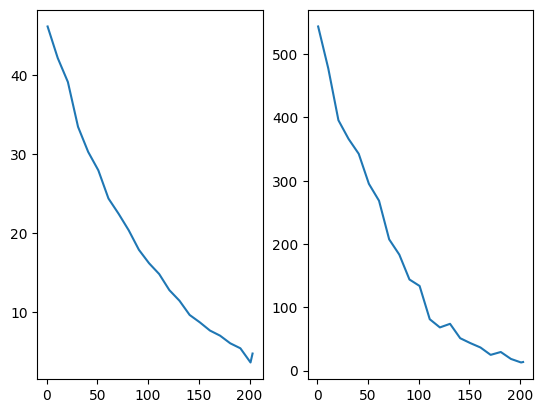

In [93]:
plt.subplot(121)
# plt.plot(monitorbam.nevals, monitorbam.rkl)
plt.plot(monitor2.nevals, monitor2.rkl)
# plt.loglog()
plt.subplot(122)
# plt.plot(monitorbam.nevals, monitorbam.fkl)
plt.plot(monitor2.nevals, monitor2.fkl)
# plt.loglog()

[ 0  2 57 12 39]


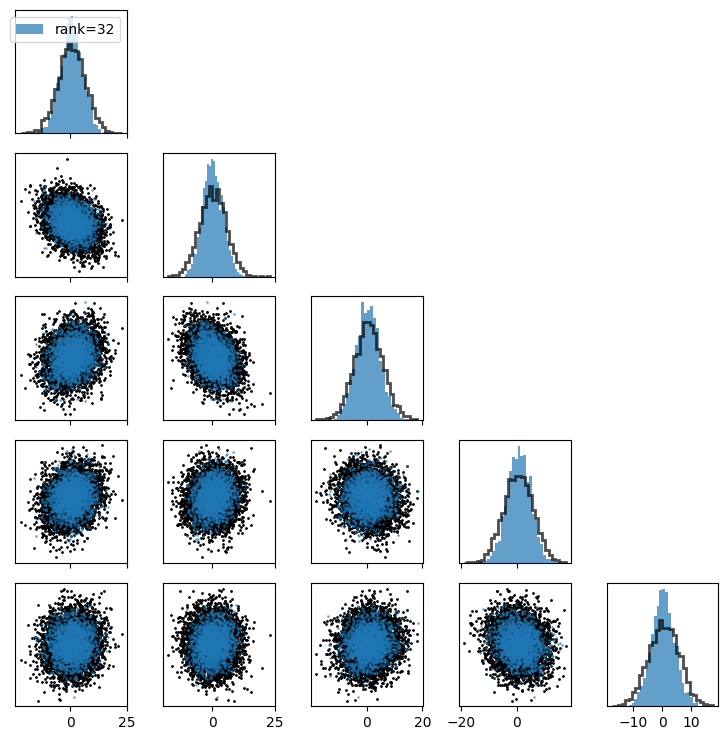

In [94]:
s = ref_samples[:5000, :] 
eps = np.random.normal(0, 1, (2000, D))
z = np.random.normal(0, 1, (2000, ranklr))
s3 = meanpgsm + psipgsm*eps + (llambdapgsm@z.T).T
# s1 = np.random.multivariate_normal(meanfit, covfit, 2000)
s1 = None
# s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
s2 = None
# s3 = np.random.multivariate_normal(meanfit3, covfit3, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            if s1 is not None: ax[i, i].hist(s1[..., ii], alpha=0.7, density=True, bins=30, label=f"BAM");
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            if s2 is not None: ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}-fullcov");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            if s1 is not None: ax[j, i].plot(s1[..., ii], s1[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            if s2 is not None: ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()



# timings

## scaling with dims

In [ ]:
ranklr = 8
batch_size = 2
niter = 20
nprint = -1
regf = lambda x: 100


tfull, tlr = [], []
dimsfull, dimslr = [], []
for i in range(3, 12):
    D = 2**i
    dimslr.append(D)
    print(D)
    model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=8)
    lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
    lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

    
    if D < 500:
        dimsfull.append(D)
        alg2 = PBAM_fullcov(D, lp_vmap, lp_g_vmap)
        key = jax.random.PRNGKey(2)
        alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, monitor=None, early_stop=False, verbose=False)


    alg3 = PBAM(D, lp_vmap, lp_g_vmap)
    key = jax.random.PRNGKey(2)
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, verbose=False)
    

    if D < 500:
        start = time()
        alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=None, early_stop=False, verbose=False)
        tfull.append(time()-start)

    start = time()
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
    tlr.append(time()-start)

dimsfull = np.array(dimsfull )
dimslr = np.array(dimslr )
tfull = np.array(tfull)
tlr = np.array(tlr)



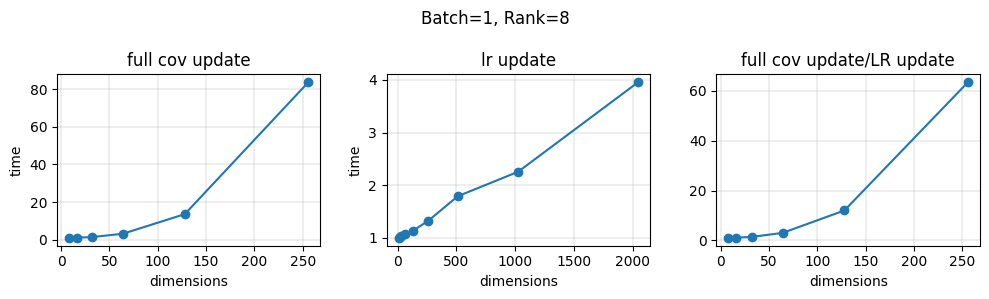

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(dimsfull, tfull/tfull[0], marker='o')
ax[0].set_title('full cov update')
ax[1].plot(dimslr, tlr/tlr[0], marker='o')
ax[1].set_title('lr update')
ax[2].plot(dimsfull, tfull/tfull[0]/tlr[:len(dimsfull)]*tlr[0], marker='o')
ax[2].set_title('full cov update/LR update')
for axis in ax[:2]: 
    # axis.loglog()
    axis.set_ylabel('time')
for axis in ax:
    axis.set_xlabel('dimensions')
    axis.grid(which='both', lw=0.3)
plt.suptitle(f'Batch={batch_size}, Rank={ranklr}')
plt.tight_layout()
 


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(dimsfull, tfull/tfull[0], marker='o')
ax[0].set_title('full cov update')
ax[1].plot(dimslr, tlr/tlr[0], marker='o')
ax[1].set_title('lr update')
ax[2].plot(dimsfull, tfull/tfull[0]/tlr[:len(dimsfull)]*tlr[0], marker='o')
ax[2].set_title('full cov update/LR update')
for axis in ax[:2]: 
    axis.loglog()
    axis.set_ylabel('time')
for axis in ax:
    axis.set_xlabel('dimensions')
    axis.grid(which='both', lw=0.3)
plt.suptitle(f'Batch={batch_size}, Rank={rank}')
plt.tight_layout()
 


In [19]:
# rank = 8 
# ranklr = 4
# batch_size = 4
# niter = 20
# nprint = -1
# regf = lambda x: 100



# tlr = []
# dimslr = []
# for i in range(3, 12):
#     D = 2**i
#     dimslr.append(D)
#     print(D)
#     model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=8)
#     lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
#     lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


#     alg3 = PBAM(D, lp_vmap, lp_g_vmap)
#     key = jax.random.PRNGKey(2)
#     alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=5, regf=regf, nprint=nprint, verbose=False)
    
#     start = time()
#     alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
#     tlr.append(time()-start)

# tlr = np.array(tlr)

8
jit psi/llambda update
16
jit psi/llambda update
32
jit psi/llambda update
64
jit psi/llambda update
128
jit psi/llambda update
256
jit psi/llambda update
512
jit psi/llambda update
1024
jit psi/llambda update
2048
jit psi/llambda update


In [37]:
# # plt.plot(dimslr, tlr/tlr[0], marker='o')
# plt.plot(dimslr, tlr, marker='o')
# plt.loglog()


## scaling with rank & batch

In [67]:
batch_size = 1
niter = 20
nprint = -1
regf = lambda x: 100

D = 512
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=256)
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

ranks = []
tranks = []

for i in range(1, 10):
    
    ranklr = 2**i
    print(ranklr)
    ranks.append(ranklr)
    alg3 = PBAM(D, lp_vmap, lp_g_vmap)
    key = jax.random.PRNGKey(2)
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, verbose=False)

    start = time()
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
    tranks.append(time()-start)

ranks = np.array(ranks)
tranks = np.array(tranks)

2
jit pbam update
jit psi/llambda update
4
jit pbam update
jit psi/llambda update
8
jit pbam update
jit psi/llambda update
16
jit pbam update
jit psi/llambda update
32
jit pbam update
jit psi/llambda update
64
jit pbam update
jit psi/llambda update
128
jit pbam update
jit psi/llambda update
256
jit pbam update
jit psi/llambda update
512
jit pbam update
jit psi/llambda update


(0.01, 100.0)

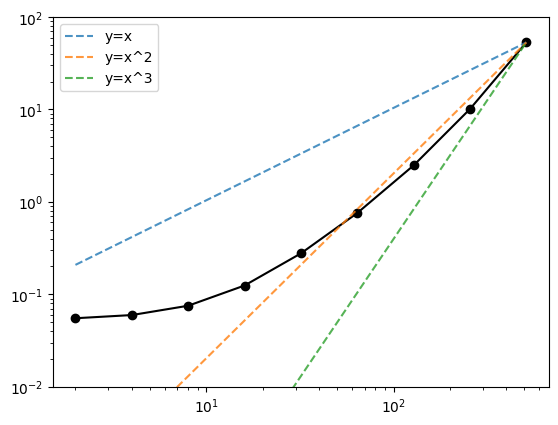

In [76]:
plt.plot(ranks, tranks, 'k', marker='o')
plt.plot(ranks, ranks/ranks[-1]*tranks[-1],  alpha=0.8, ls='--', label='y=x')
plt.plot(ranks, ranks**2/ranks[-1]**2*tranks[-1], alpha=0.8, ls='--', label='y=x^2')
plt.plot(ranks, ranks**3/ranks[-1]**3*tranks[-1],  alpha=0.8, ls='--', label='y=x^3')
plt.loglog()
plt.legend()
plt.ylim(1e-2, 1e2)

In [69]:
ranklr = 4
niter = 20
nprint = -1
regf = lambda x: 100


D = 512
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=256)
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

batches = []
tbatches = []

for i in range(1, 8):
    
    batch_size = 2**i
    print(batch_size)
    batches.append(batch_size)
    alg3 = PBAM(D, lp_vmap, lp_g_vmap)
    key = jax.random.PRNGKey(2)
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, verbose=False)

    start = time()
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
    tbatches.append(time()-start)

batches = np.array(batches)
tbatches = np.array(tbatches)

2
jit pbam update
jit psi/llambda update
4
jit pbam update
jit psi/llambda update
8
jit pbam update
jit psi/llambda update
16
jit pbam update
jit psi/llambda update
32
jit pbam update
jit psi/llambda update
64
jit pbam update
jit psi/llambda update
128
jit pbam update
jit psi/llambda update


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


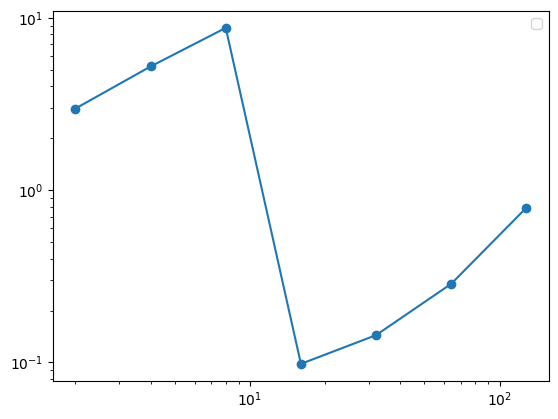

In [79]:
plt.plot(batches, tbatches, marker='o')
# plt.plot(batches, batches/batches[-1]*tbatches[0], color='k', alpha=0.8, ls='--', label='y=x')
# plt.plot(batches, batches**2/batches[0]**2*tbatches[0], color='k', alpha=0.8, ls='--', label='y=x^2')
# plt.plot(batches, batches**3/batches[0]**3*tbatches[0], color='k', alpha=0.8, ls='--', label='y=x^3')
plt.loglog()
plt.legend()

# image


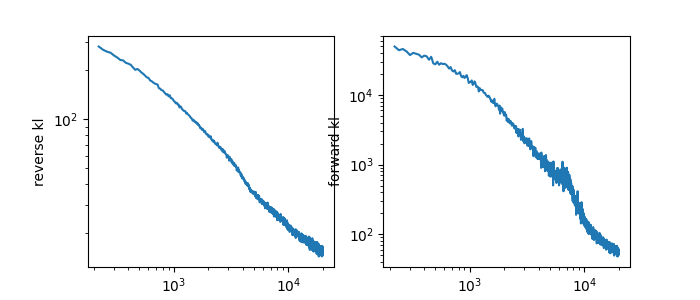

In [287]:
Image('../scripts/tmp/pbam1024-loss-test.png')

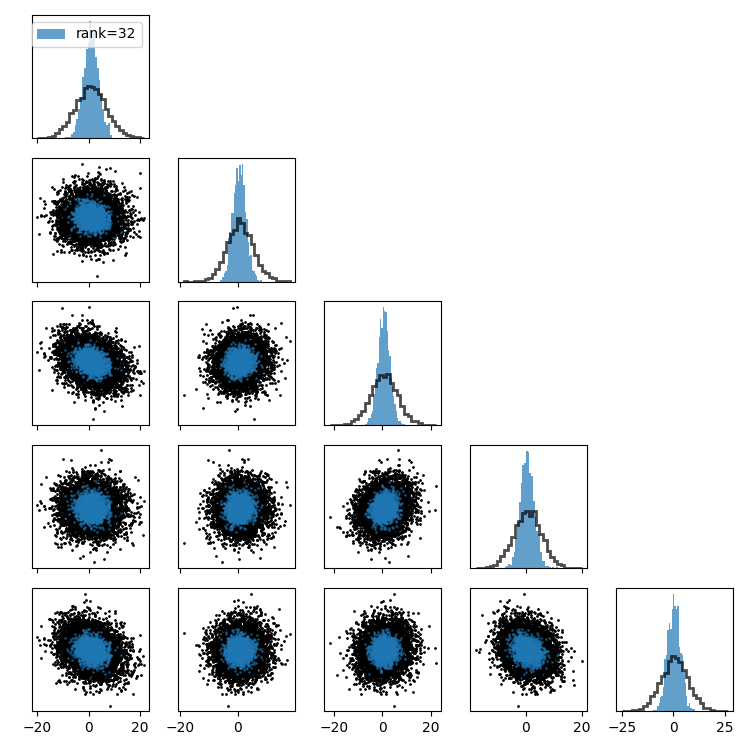

In [288]:

Image('../scripts/tmp/pbam1024-hist-test.png')

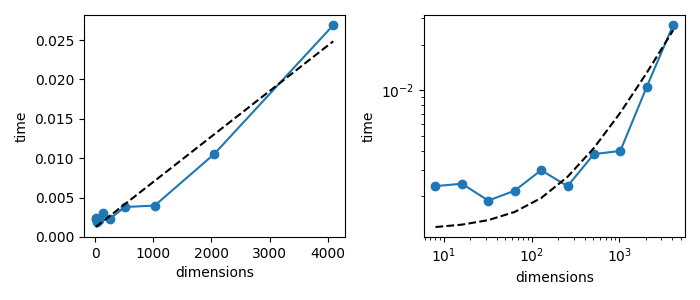

In [113]:
Image('../scripts/tmp/timing.png')

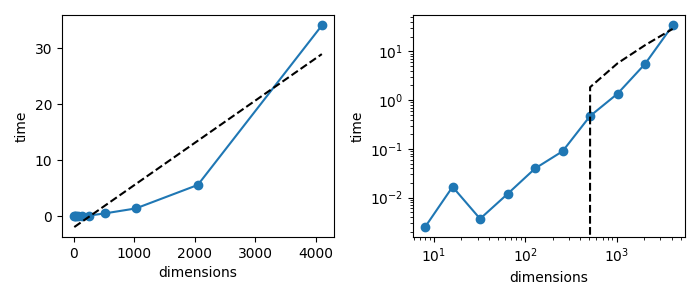

In [114]:
Image('../scripts/tmp/timing_fullcov.png')

In [88]:
m = np.random.random((256, 256, 256))

In [58]:
# for i in range(3):
#     [j.mean(axis=i) for j in np.split(m, 8, i)]

In [86]:
n = np.array([j.mean(axis=i) for i in range(3) for j in np.split(m, 8, i)])

In [80]:
n.shape

(24, 256, 256)

In [95]:
%%timeit
np.array([j.mean(axis=i) for i in range(3) for j in np.split(m, 8, i)])

79.7 ms ± 922 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
D = 8
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=4)

In [98]:
%timeit model.log_prob(ref_samples)

1.33 ms ± 72.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [103]:
t = []
for i in range(3, 13):
    D = 2**i
    model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=4)   
    start = time()
    for _ in range(20):
        model.log_prob(ref_samples*(1+0.01*np.random.random()))
    t.append(time() - start)
    

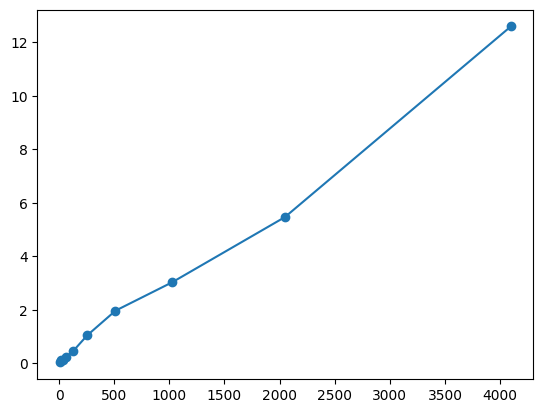

In [106]:
plt.plot(2**np.arange(3, 13), t, marker='o')


In [121]:
t0 = np.load('../scripts/tmp/timings-2.npy')
t1 = np.load('../scripts/tmp/timings_fullcov-2.npy')

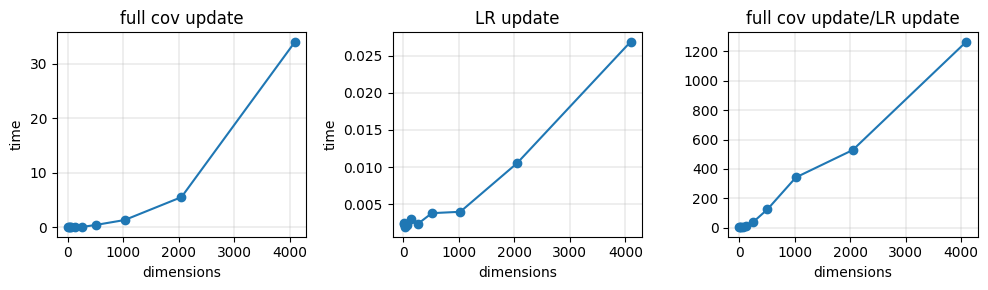

In [143]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(*t1, marker='o')
ax[1].plot(*t0, marker='o')
ax[2].plot(t0[0], t1[1]/t0[1], marker='o')

ax[0].set_title('full cov update')
ax[1].set_title('LR update')
ax[2].set_title('full cov update/LR update')
for axis in ax[:2]: 
    # axis.loglog()
    axis.set_ylabel('time')
for axis in ax:
    axis.set_xlabel('dimensions')
    axis.grid(which='both', lw=0.3)
# plt.suptitle(f'Batch={batch_size}, Rank={ranklr}')
plt.tight_layout()
 


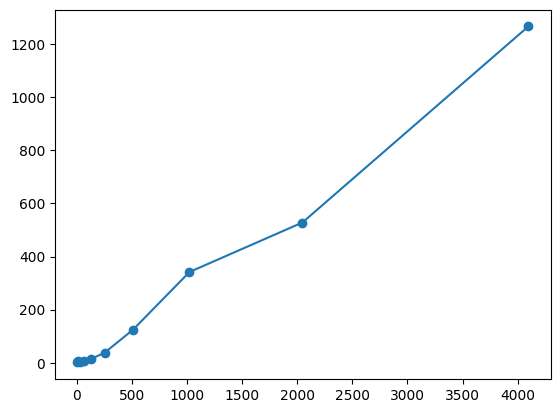

# vs bbvi

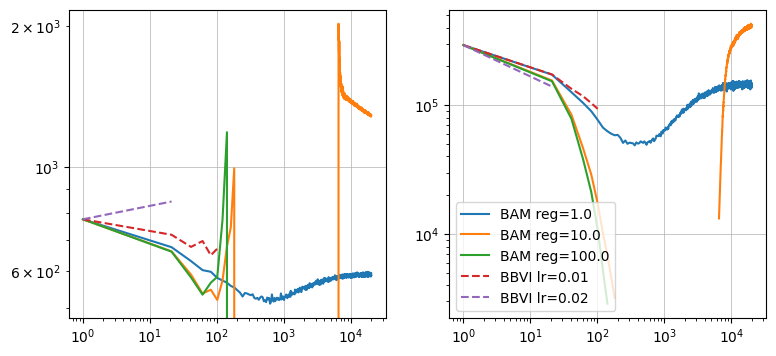

In [170]:
D = 256


fig, ax = plt.subplots(1, 2, figsize=(9, 4))

for reg in [1., 10., 100.]:
    try:
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BAM reg={reg:0.1f}')
        ax[1].plot(g, fkl, label=f'BAM reg={reg:0.1f}')
    except Exception as e:
        print(e)

# for _ in [1]:
#     try:
#         g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/nevals.npy')
#         rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/rkl.npy')
#         fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/fkl.npy')
#         ax[0].plot(g, rkl, label='GSM')
#         ax[1].plot(g, fkl, label='GSM')
#     except Exception as e:
#         print(e)

for lr in [0.01, 0.02]:
# for lr in [0.01, 0.02, 0.05, 0.1]:
    try: 
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BBVI lr={lr:0.2f}', ls="--")
        ax[1].plot(g, fkl, label=f'BBVI lr={lr:0.2f}', ls="--")
    except Exception as e:
        print(e)
    
for axis in ax:
    axis.loglog()
    axis.grid(lw=0.5)
plt.legend()

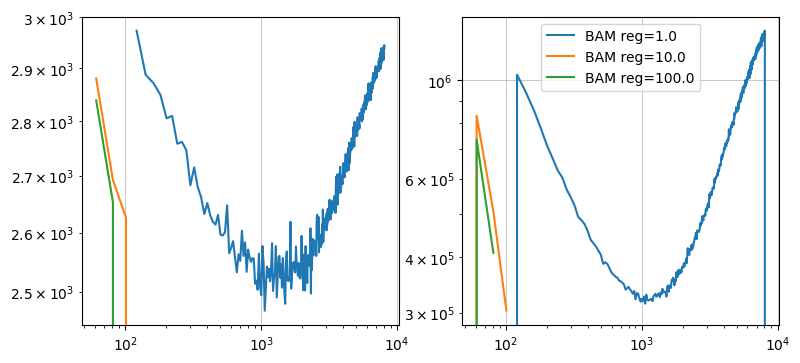

In [144]:
D = 1024


fig, ax = plt.subplots(1, 2, figsize=(9, 4))

for reg in [1., 10., 100.]:
    try:
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BAM reg={reg:0.1f}')
        ax[1].plot(g, fkl, label=f'BAM reg={reg:0.1f}')
    except Exception as e:
        print(e)

# for _ in [1]:
#     try:
#         g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/nevals.npy')
#         rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/rkl.npy')
#         fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/fkl.npy')
#         ax[0].plot(g, rkl, label='GSM')
#         ax[1].plot(g, fkl, label='GSM')
#     except Exception as e:
#         print(e)

# for lr in [0.01, 0.02]:
# # for lr in [0.01, 0.02, 0.05, 0.1]:
#     try: 
#         g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/nevals.npy')
#         rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/rkl.npy')
#         fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/fkl.npy')
#         ax[0].plot(g, rkl, label=f'BBVI lr={lr:0.2f}', ls="--")
#         ax[1].plot(g, fkl, label=f'BBVI lr={lr:0.2f}', ls="--")
#     except Exception as e:
#         print(e)
    
for axis in ax:
    axis.loglog()
    axis.grid(lw=0.5)
plt.legend()

In [146]:
np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/mean_fit.npy')

array([-1.76041198e+37,  8.14202273e+37,  1.44470695e+38, ...,
       -1.58287104e+37,  2.38129681e+36, -3.88701222e+37])

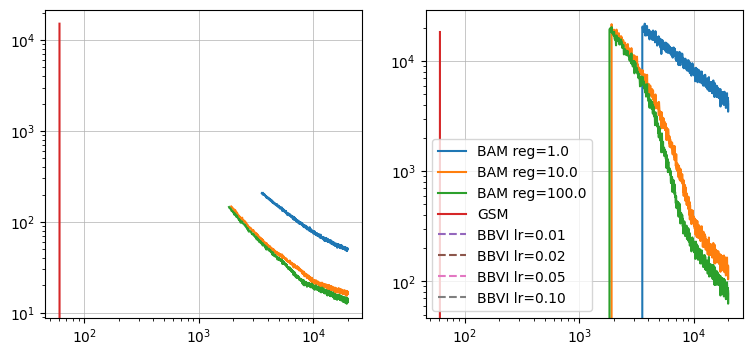

In [186]:
D = 2048

fig, ax = plt.subplots(1, 2, figsize=(9, 4))

for reg in [1., 10., 100.]:
    try:
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg{reg:0.2f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg{reg:0.2f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg{reg:0.2f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BAM reg={reg:0.1f}')
        ax[1].plot(g, fkl, label=f'BAM reg={reg:0.1f}')
    except Exception as e:
        print(e)

for _ in [1]:
    try:
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/fkl.npy')
        ax[0].plot(g, rkl, label='GSM')
        ax[1].plot(g, fkl, label='GSM')
    except Exception as e:
        print(e)

for lr in [0.01, 0.02, 0.05, 0.1]:
    try: 
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/padvi/B2-lr{lr:0.3f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/padvi/B2-lr{lr:0.3f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/padvi/B2-lr{lr:0.3f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BBVI lr={lr:0.2f}', ls="--")
        ax[1].plot(g, fkl, label=f'BBVI lr={lr:0.2f}', ls="--")
    except Exception as e:
        print(e)
    
for axis in ax:
    axis.loglog()
    axis.grid(lw=0.5)
plt.legend()

[ 34  61 127  63   5 112   3]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


autodetected range of [nan, nan] is not finite


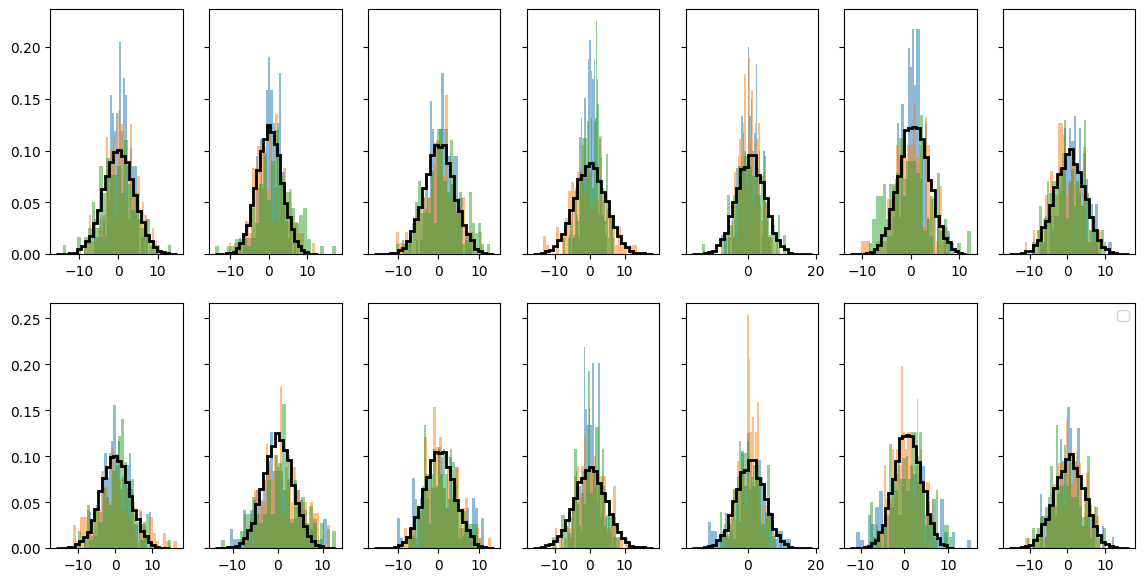

In [100]:
D = 128
K = 16
suffix = ''

meanref = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/mean.npy')
covref = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/cov.npy')
refs = np.random.multivariate_normal(meanref, covref, 10000).T

dplot = 7
idx = np.random.randint(0, D, dplot)
print(idx)

fig, ax = plt.subplots(2, dplot, figsize=(14, 7), sharex=False, sharey='row')

for i in range(dplot):
    ax[0, i].hist(refs[idx[i]], bins=30, histtype='step', lw=2, color='k', density=True)
for i in range(dplot):
    ax[1, i].hist(refs[idx[i]], bins=30, histtype='step', lw=2, color='k', density=True)

for reg in [1., 10., 100.]:
    try:
        mean = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg{reg:0.2f}/mean_fit.npy')
        psi = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg{reg:0.2f}/psi_fit.npy')
        llambda = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg{reg:0.2f}/llambda_fit.npy')
        eps = np.random.normal(0, 1, (10000, D))
        z = np.random.normal(0, 1, (10000, K))
        s = mean + psi*eps + (llambda@z.T).T
        for i in range(dplot):
            ax[0, i].hist(s[idx[i]], bins=30, alpha=0.5, density=True)
    except Exception as e:
        print(e)


# for _ in [1]:
#     try:
#         mean = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/mean_fit.npy')
#         psi = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/psi_fit.npy')
#         llambda = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/llambda_fit.npy')
#         eps = np.random.normal(0, 1, (5000, D))
#         z = np.random.normal(0, 1, (5000, K))
#         s = mean + psi*eps + (llambda@z.T).T
#         for i in range(5):
#             ax[0, i].hist(s[idx[i]], bins=30, alpha=0.5, density=True)
#     except Exception as e:
#         print(e)


for lr in [0.01, 0.02, 0.05, 0.1]:
    try: 
        mean = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/padvi/B2-lr{lr:0.3f}/mean_fit.npy')
        psi = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/padvi/B2-lr{lr:0.3f}/psi_fit.npy')
        llambda = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/padvi/B2-lr{lr:0.3f}/llambda_fit.npy')
        eps = np.random.normal(0, 1, (10000, D))
        z = np.random.normal(0, 1, (10000, K))
        s = mean + psi*eps + (llambda@z.T).T
        for i in range(dplot):
            ax[1, i].hist(s[idx[i]], bins=30, alpha=0.5, density=True)
    except Exception as e:
        print(e)
    
# for axis in ax:
#     axis.loglog()
#     axis.grid(lw=0.5)
plt.legend()

0


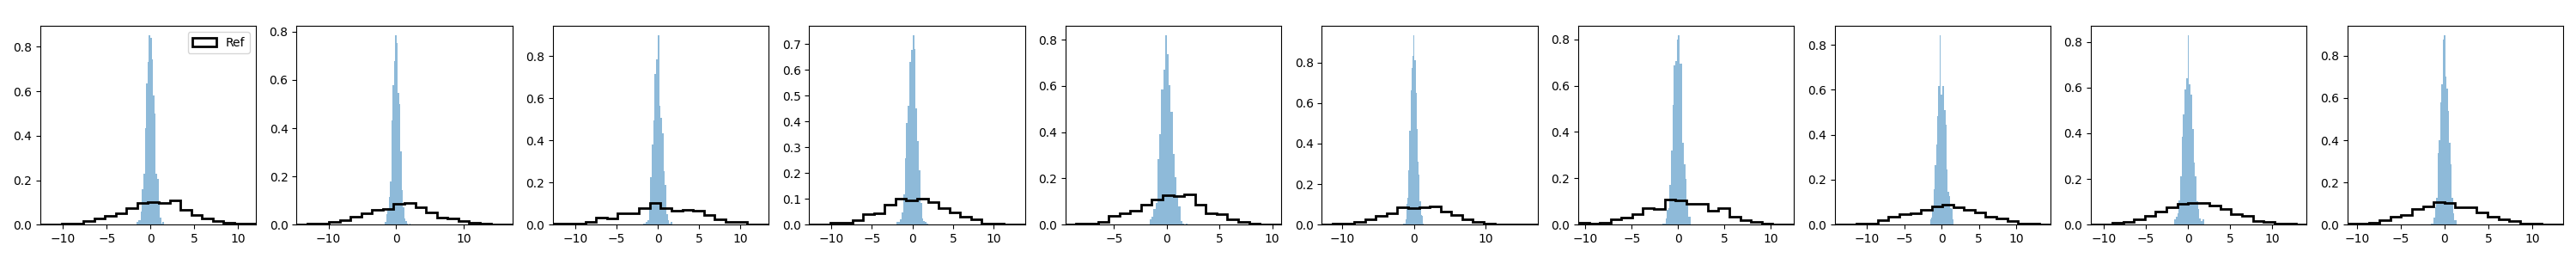

1000


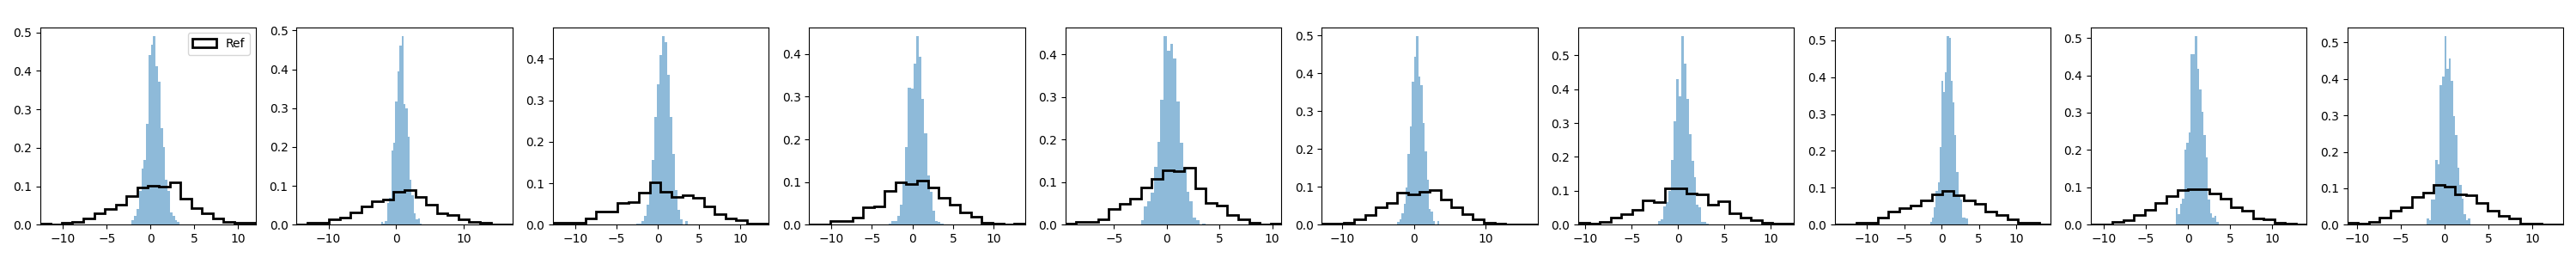

2000


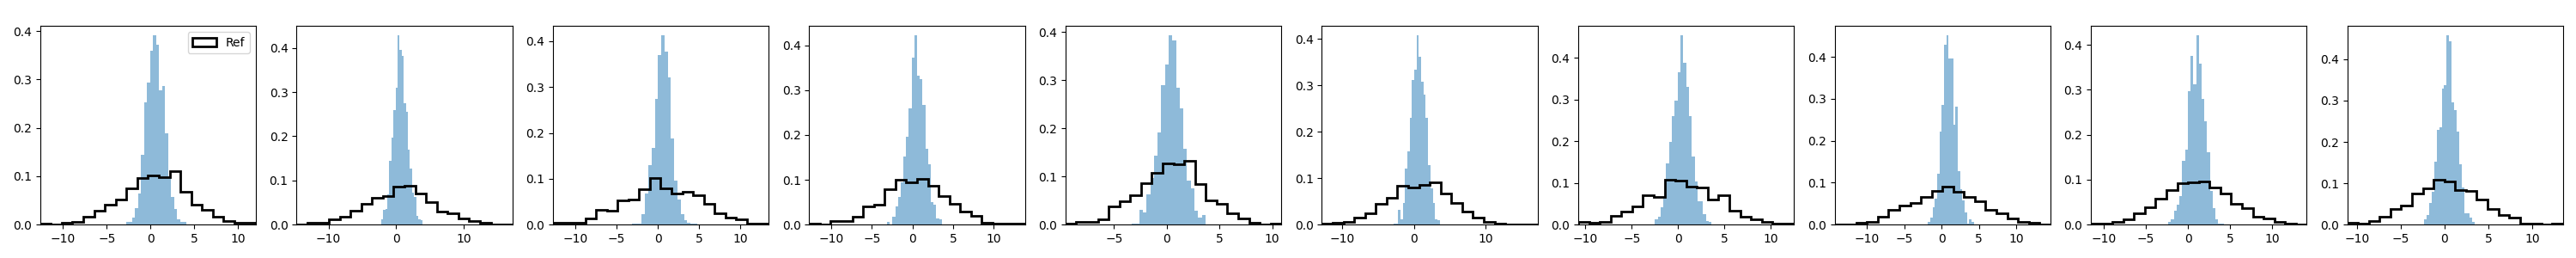

3000


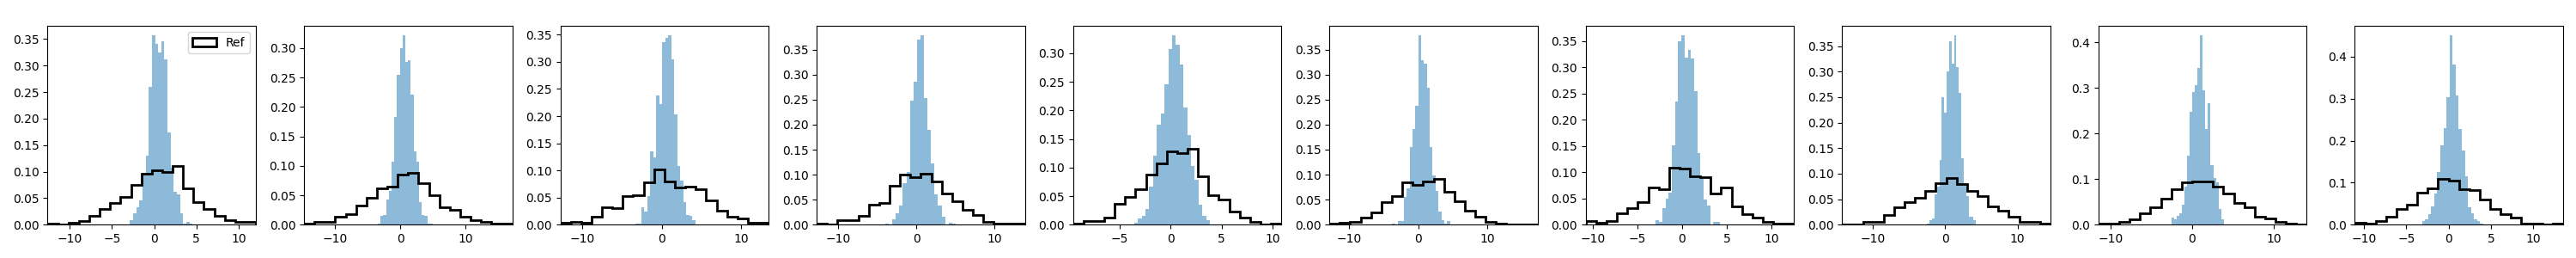

4000


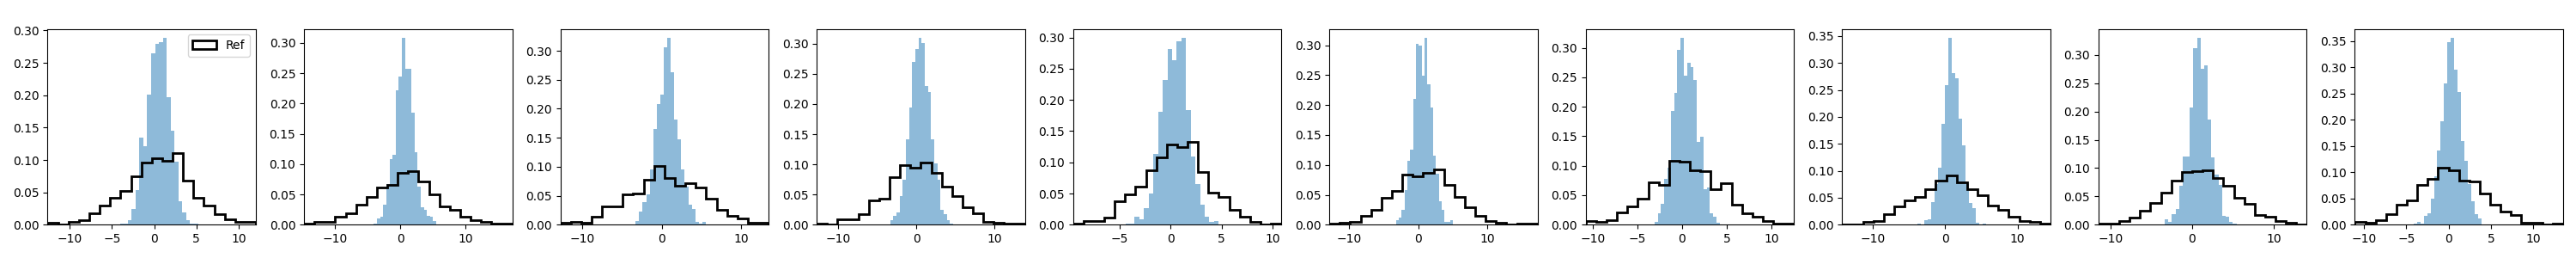

5000


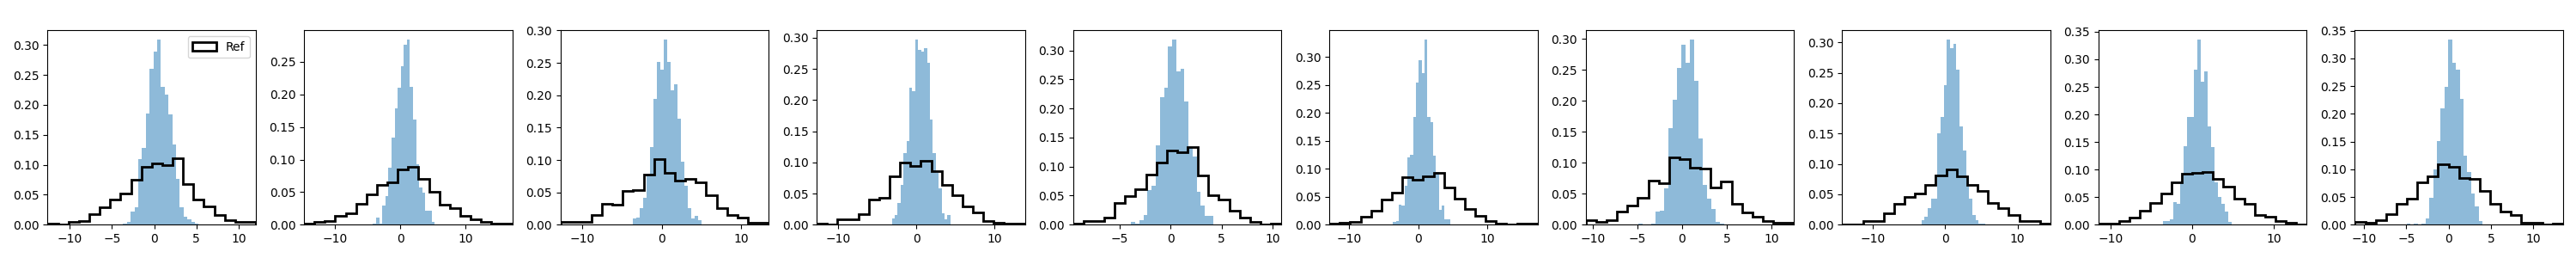

6000


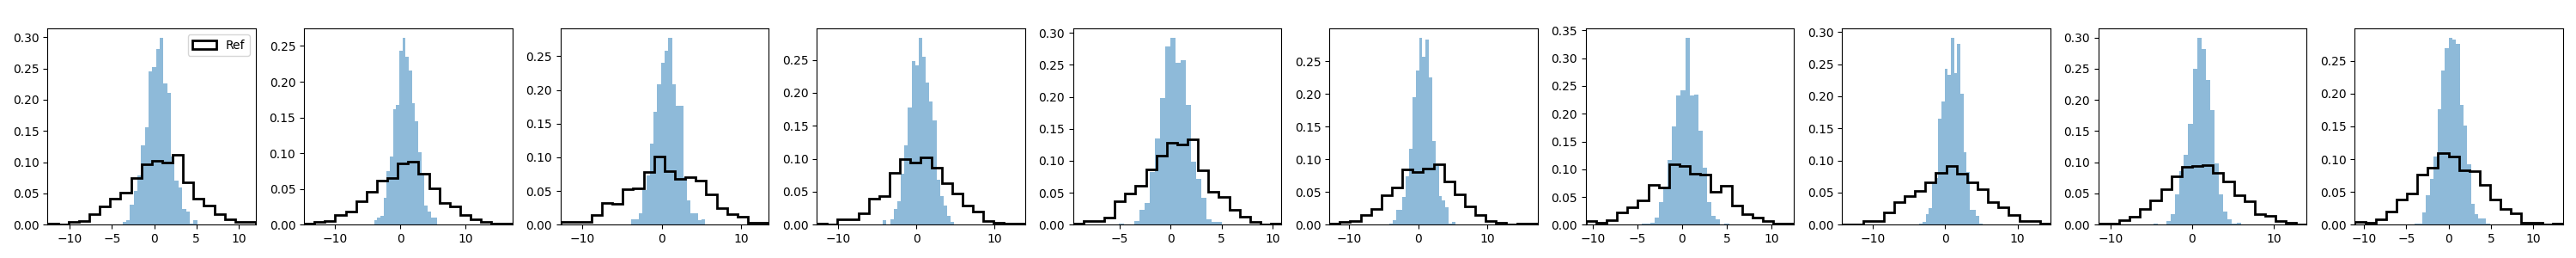

7000


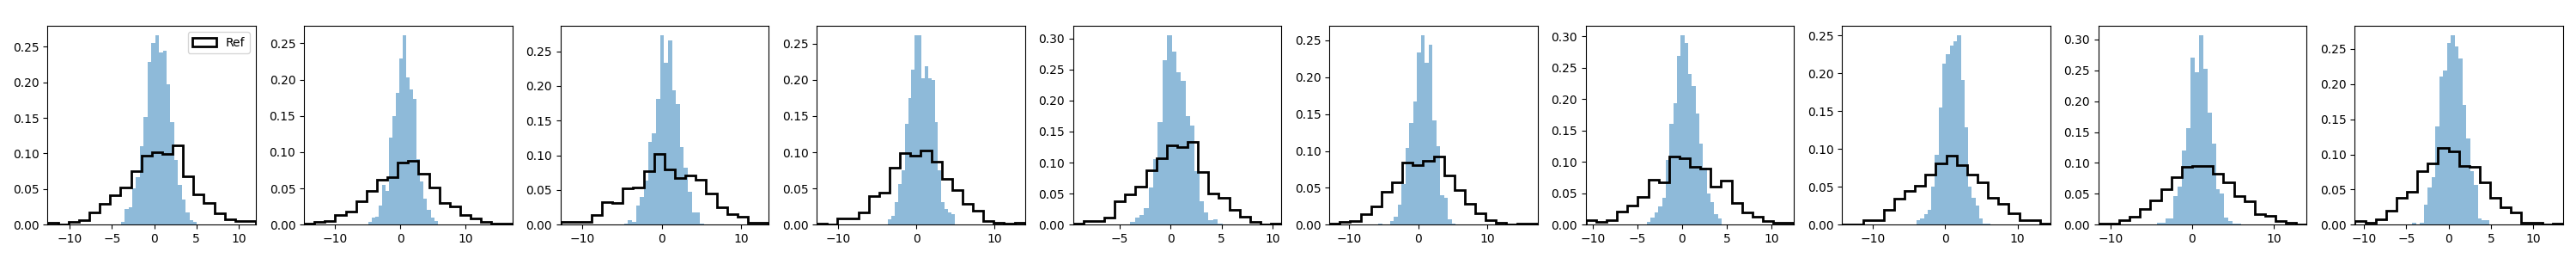

8000


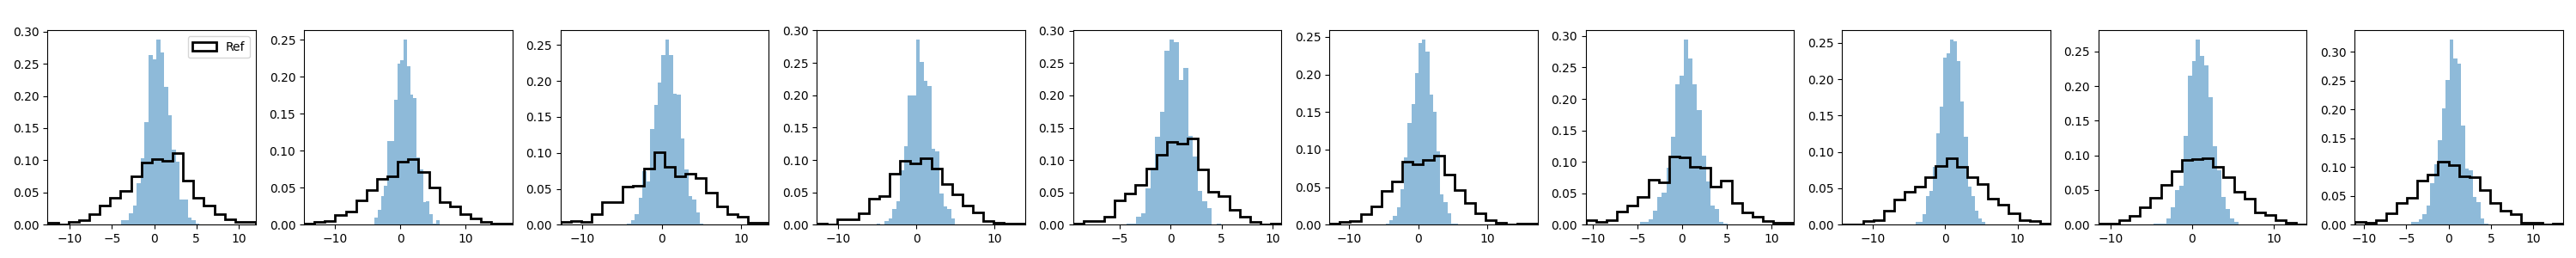

9000


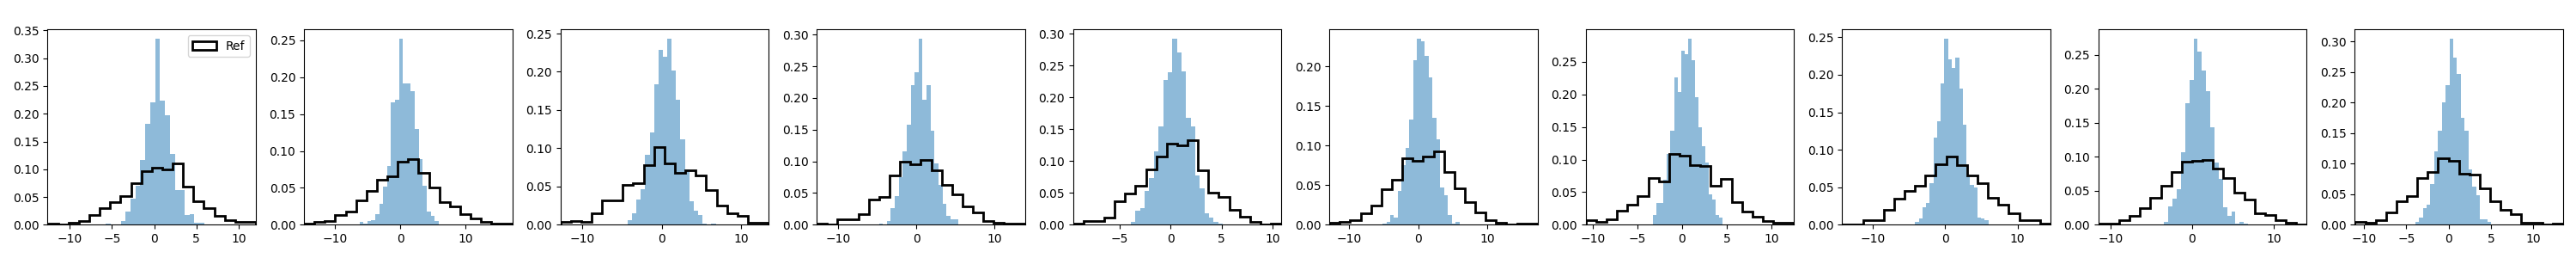

In [185]:
for i in range(0, 100, 10):
    print(i*100)
    display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D2048/R16-seed0/pbam/B2-reg100.00/hist{i*100}.png'))


(13, 2048)


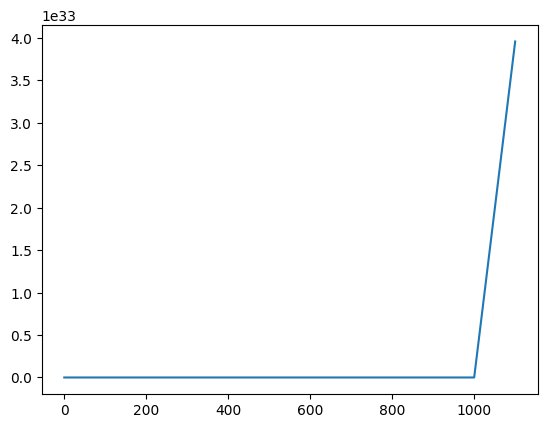

In [90]:
D = 2048
iparams = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/iparams.npy')
means = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/means.npy')
print(means.shape)
psis = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/psis.npy')
# psis = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg10.00/psis.npy')
plt.plot(iparams, psis[:-1, 0])
# llambdas = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/llambdas.npy')
# plt.plot(llambdas[:, 0, 0])
# plt.loglog()

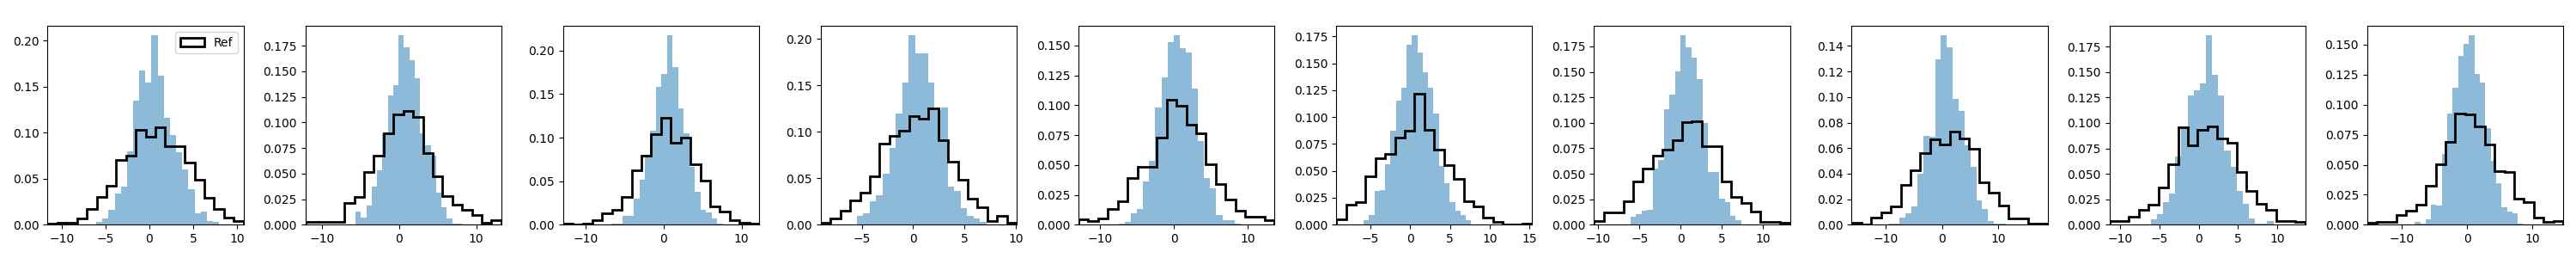

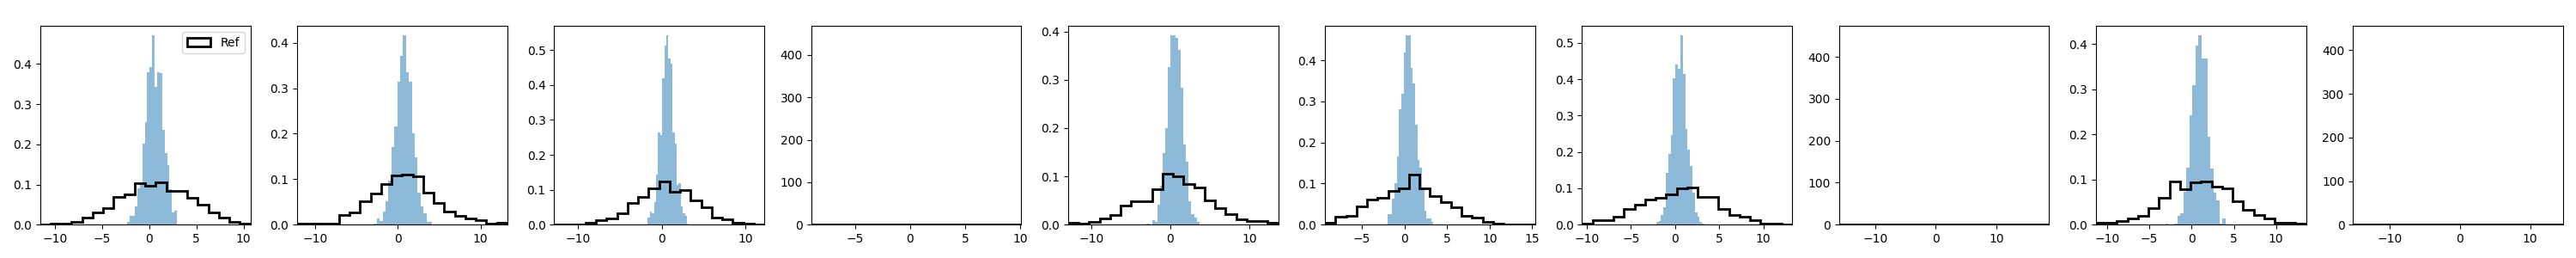

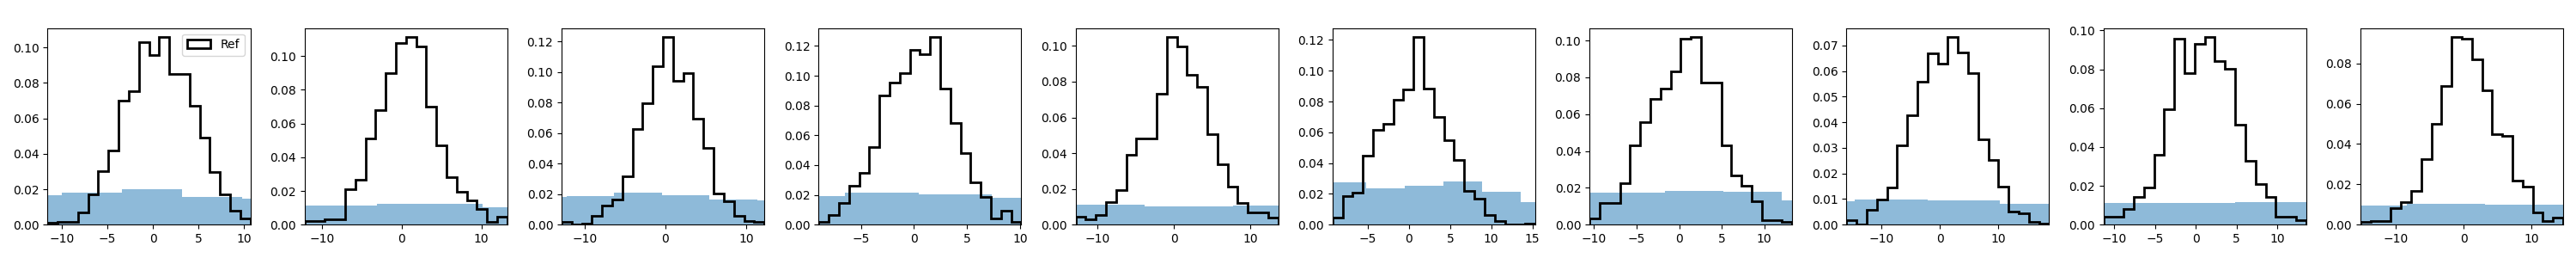

bad cond


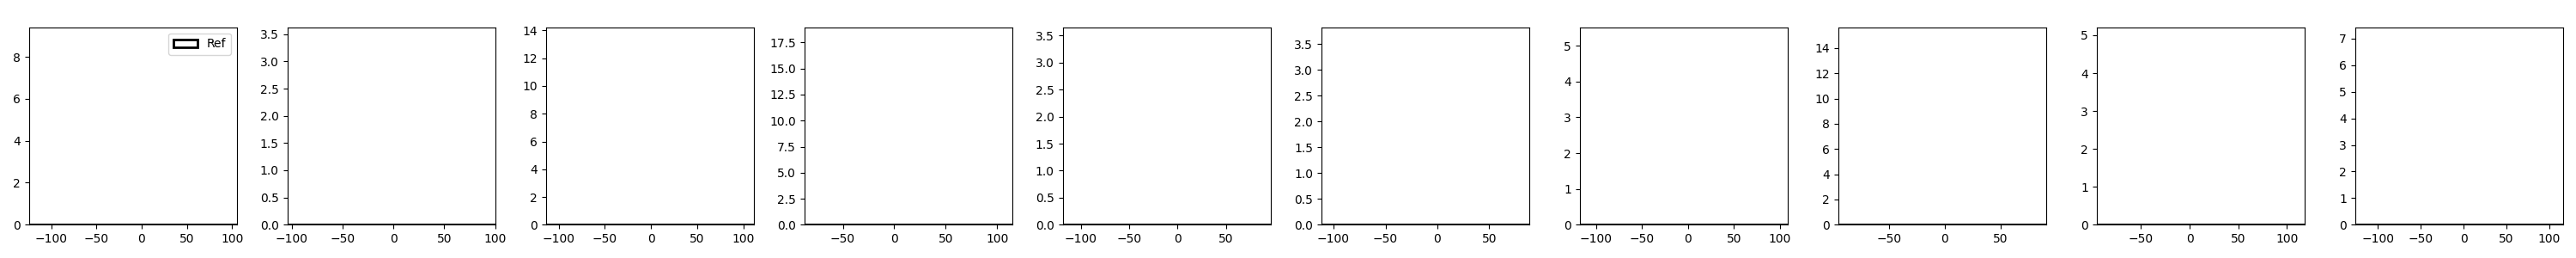

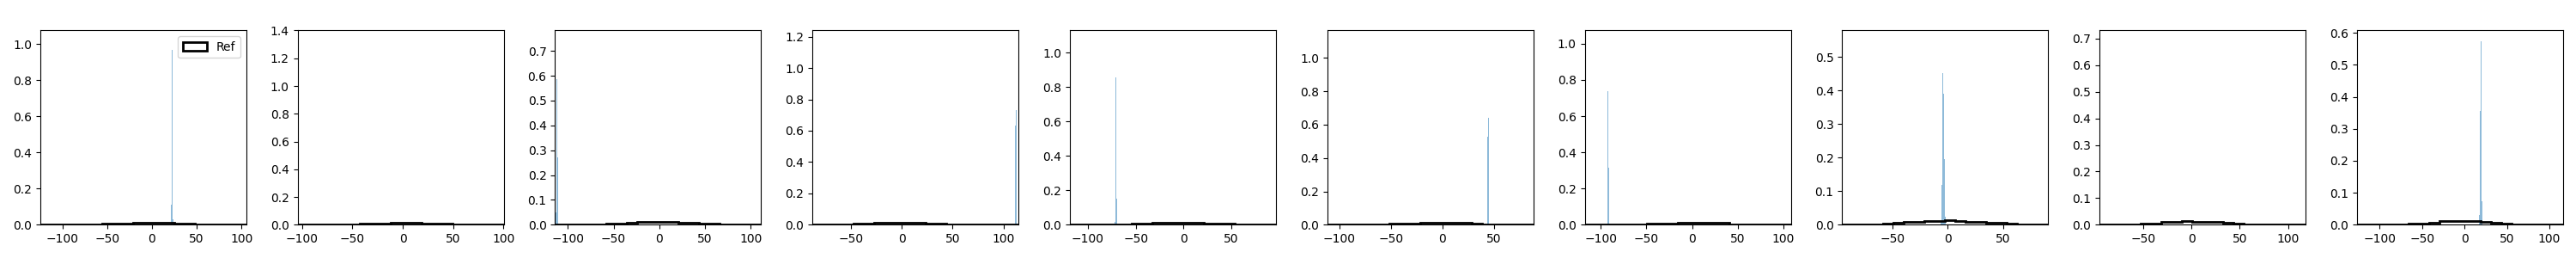

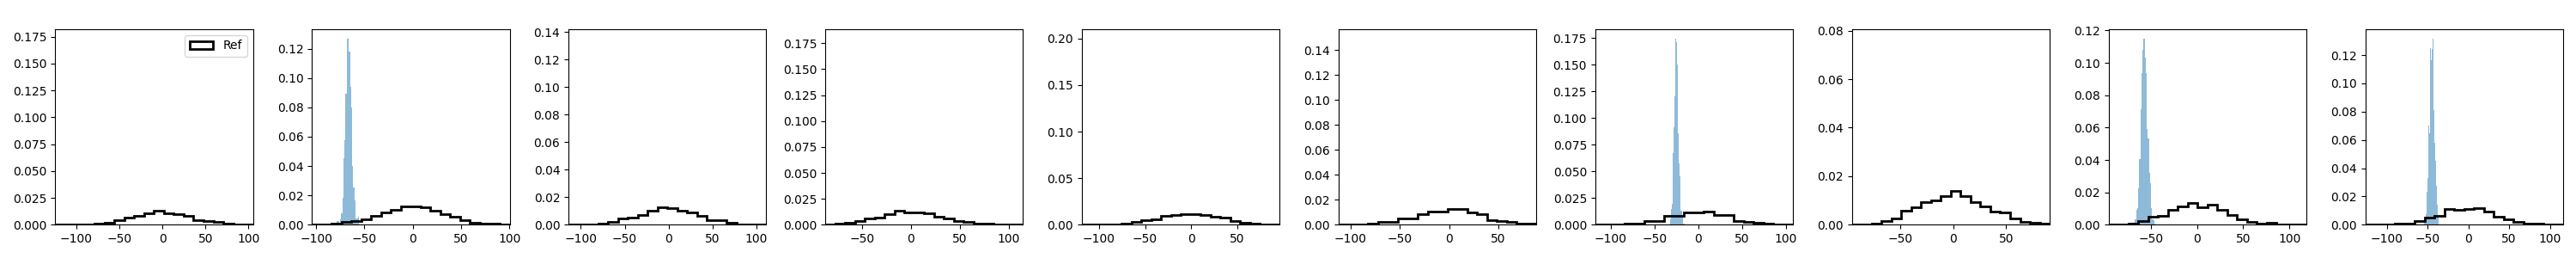

In [94]:
D=1024
suffix=''
niter=''
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00/hist{niter}.png'))
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset2/hist{niter}.png'))
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-reset/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-reset2/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset3/hist{niter}.png'))
print('bad cond')
suffix='-badcond'
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00/hist{niter}.png'))
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset2/hist{niter}.png'))
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-reset/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-reset2/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset3/hist{niter}.png'))


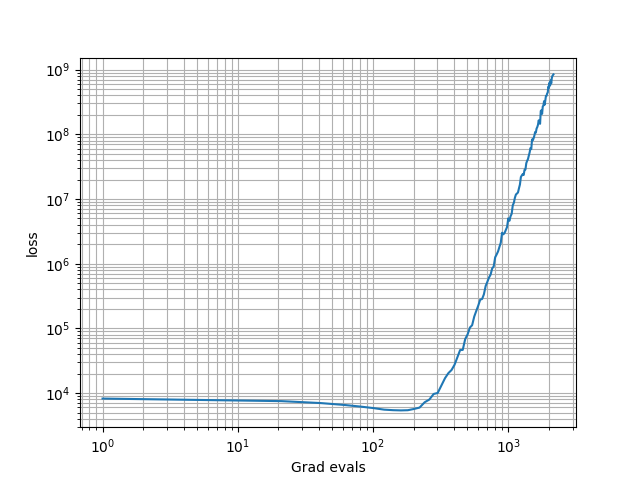

In [93]:
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D2048-badcond/R16-seed0/pbam/B2-reg10.00/rkl.png'))


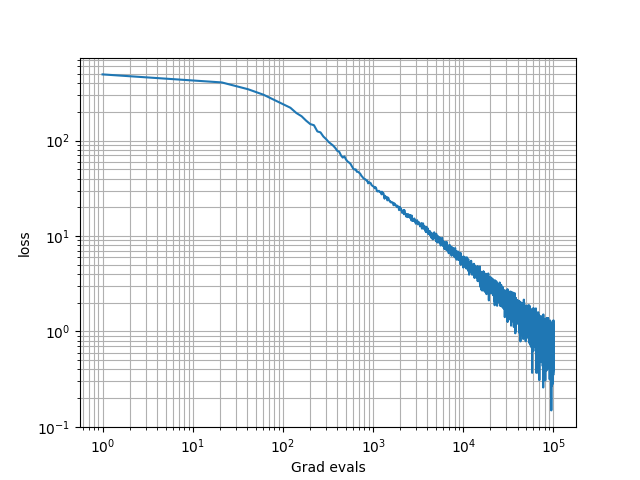

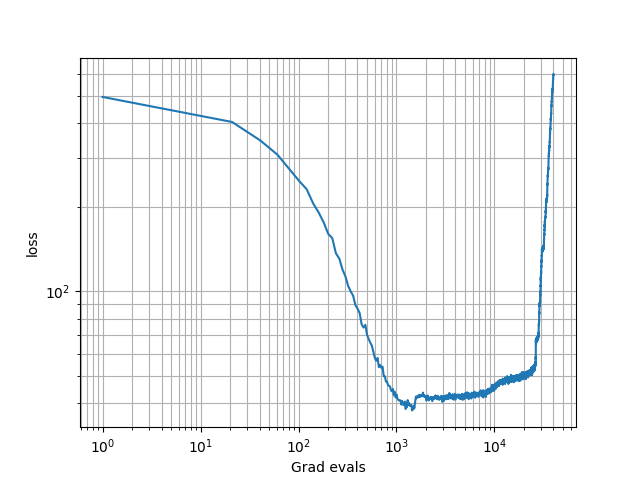

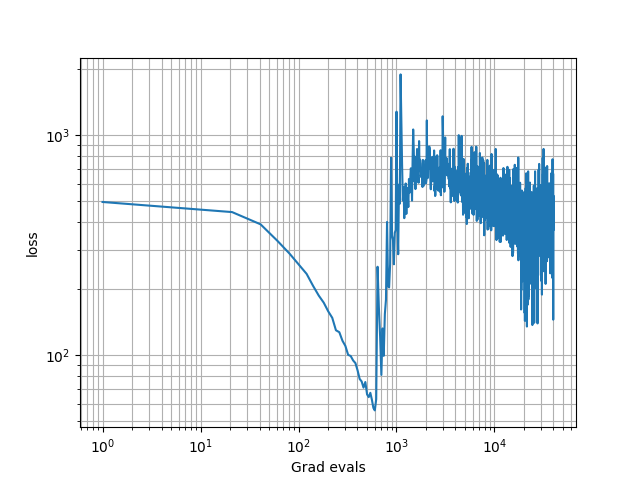

bad cond


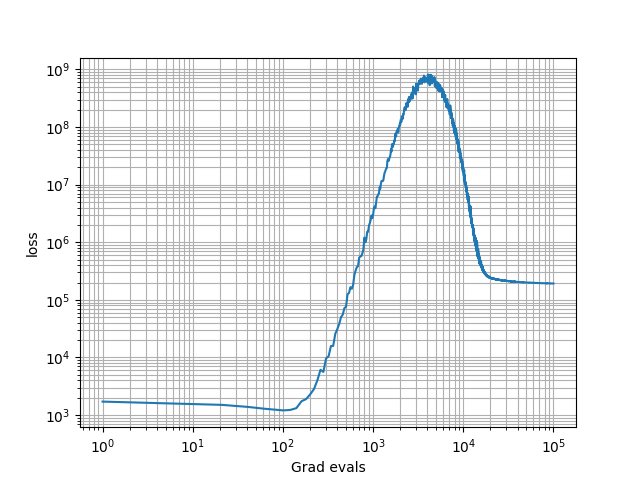

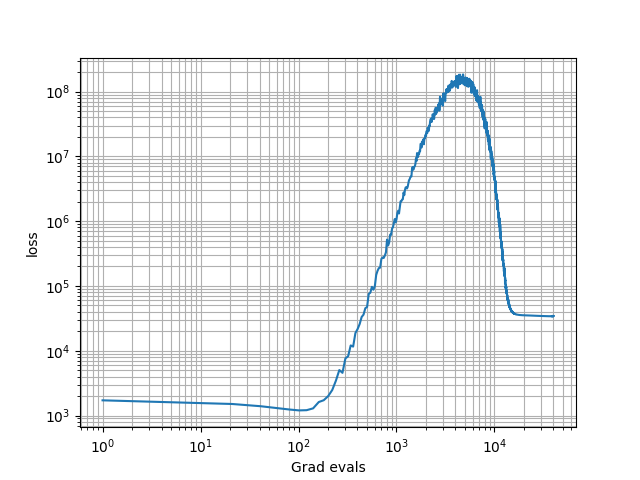

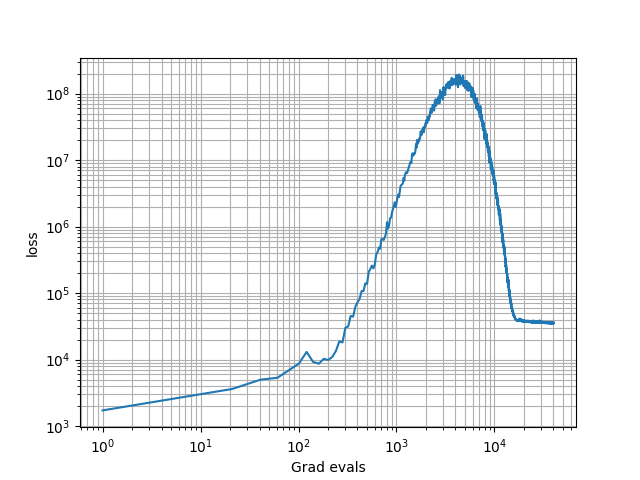

In [77]:
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00/rkl.png'))
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-psireset/rkl.png'))
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-reset/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-llambdareset/rkl.png'))
print('bad cond')
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00/rkl.png'))
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-psireset/rkl.png'))
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-reset/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-llambdareset/rkl.png'))


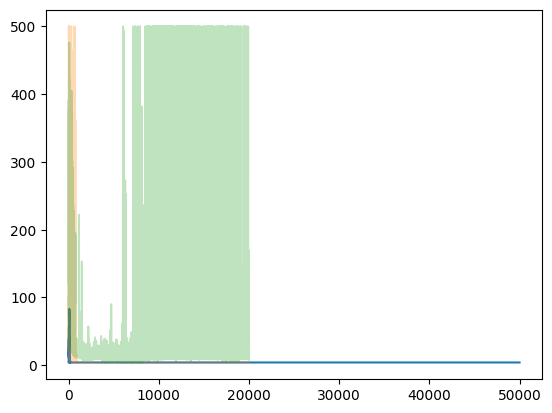

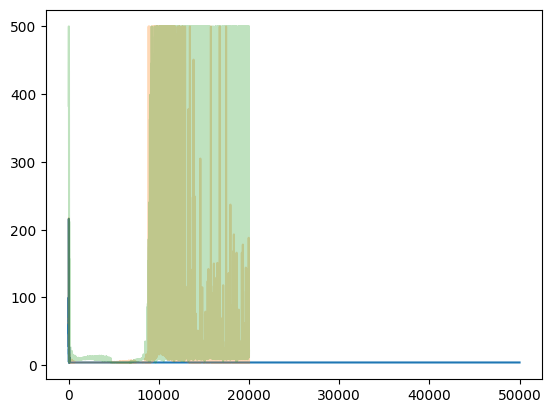

In [76]:
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00/nprojects.npy'))
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-psireset/nprojects.npy'), alpha=0.3)
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-reset/nprojects.npy'), alpha=0.3)
plt.show()
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00/nprojects.npy'))
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-psireset/nprojects.npy'), alpha=0.3)
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-reset/nprojects.npy'), alpha=0.3)


[]

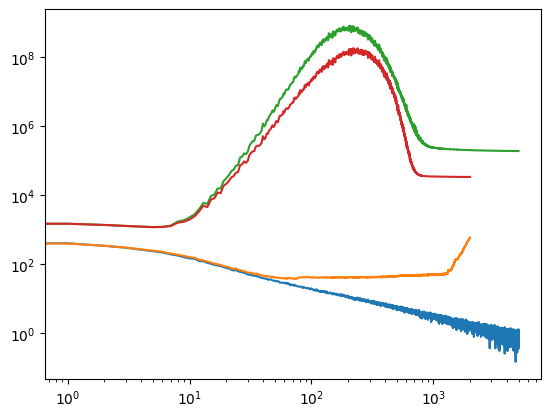

In [73]:
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00//rkl.npy'))
# plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-psireset//rkl.npy'))
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00//rkl.npy'))
# plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-psireset//rkl.npy'))
plt.loglog()
plt.xlabel('itera

[]

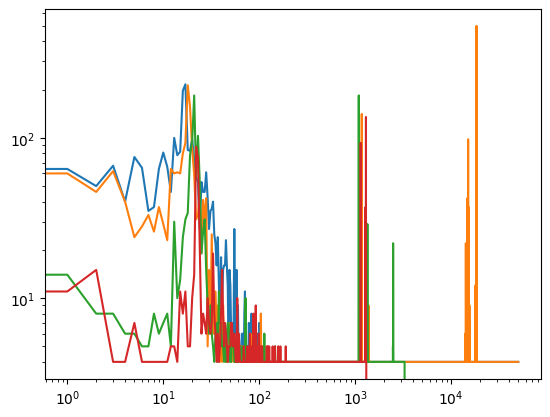

In [75]:
for D in [512, 1024, 2048, 4096]:
    plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00//nprojects.npy'))
plt.loglog()

[]

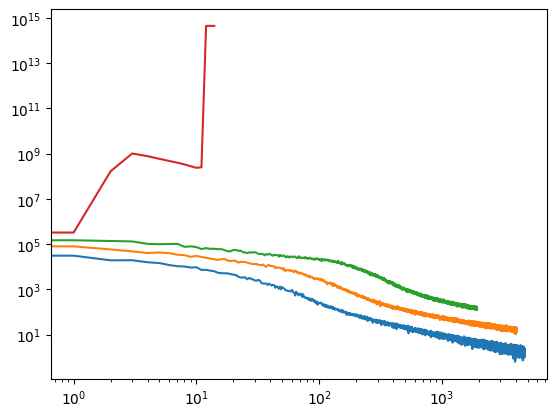

In [100]:
for D in [512, 1024, 2048, 4096]:
    plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg10.00//fkl.npy'))
    # plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/rkl.npy'))
plt.loglog()

512


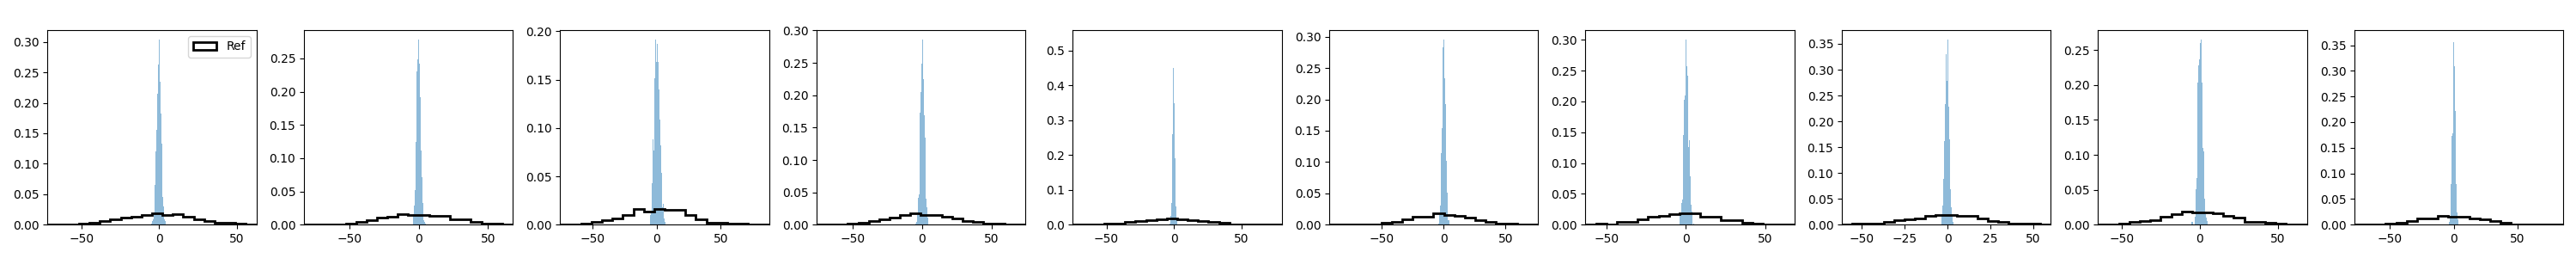

1024


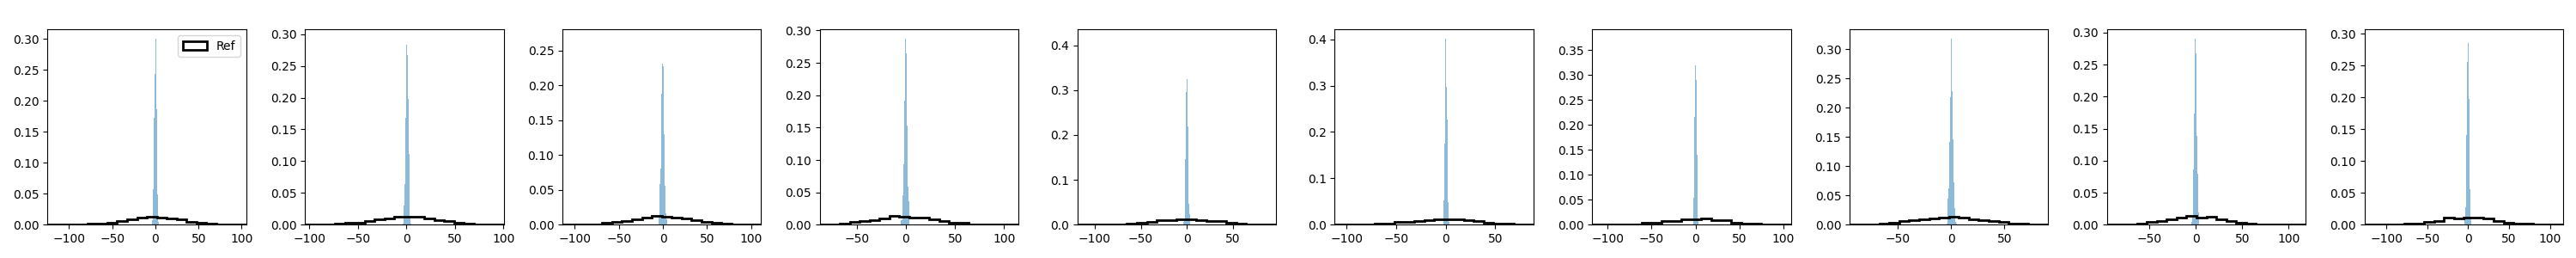

2048


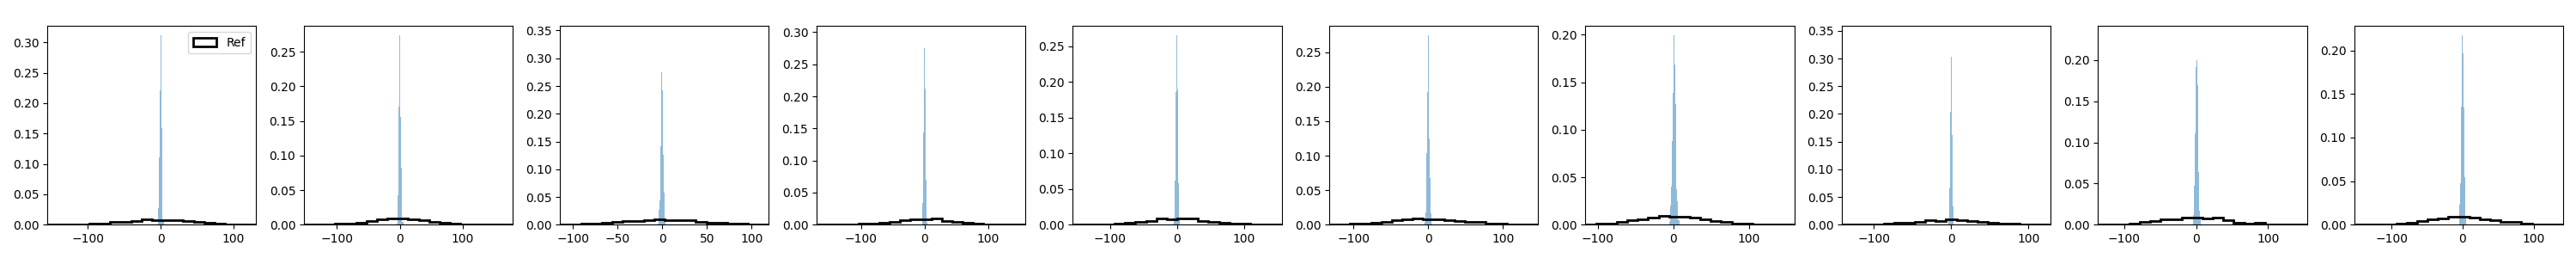

4096


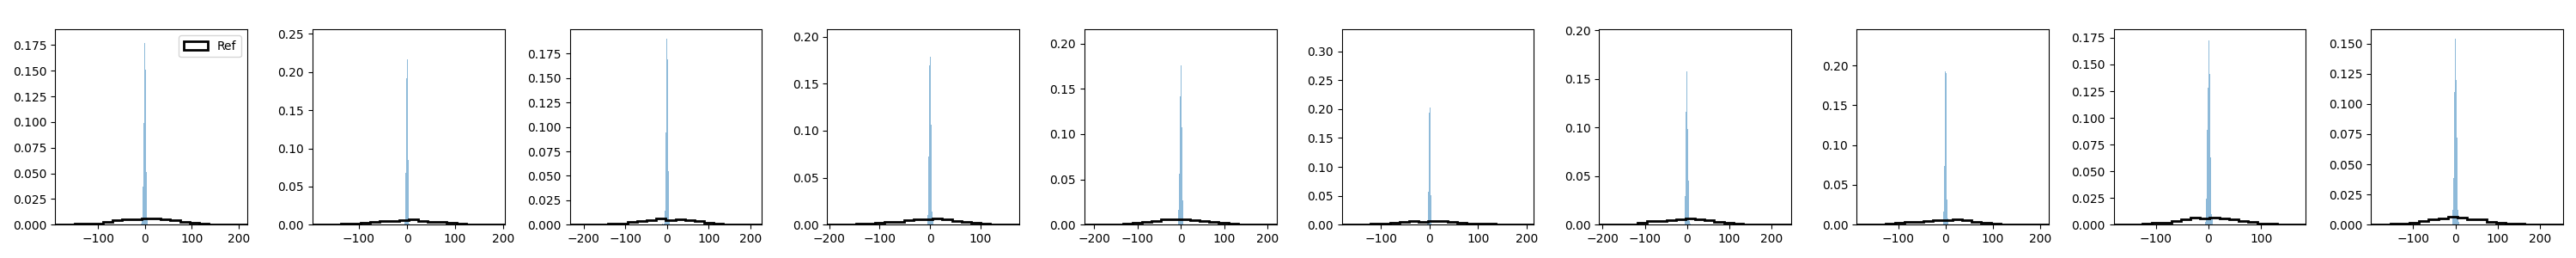

8192


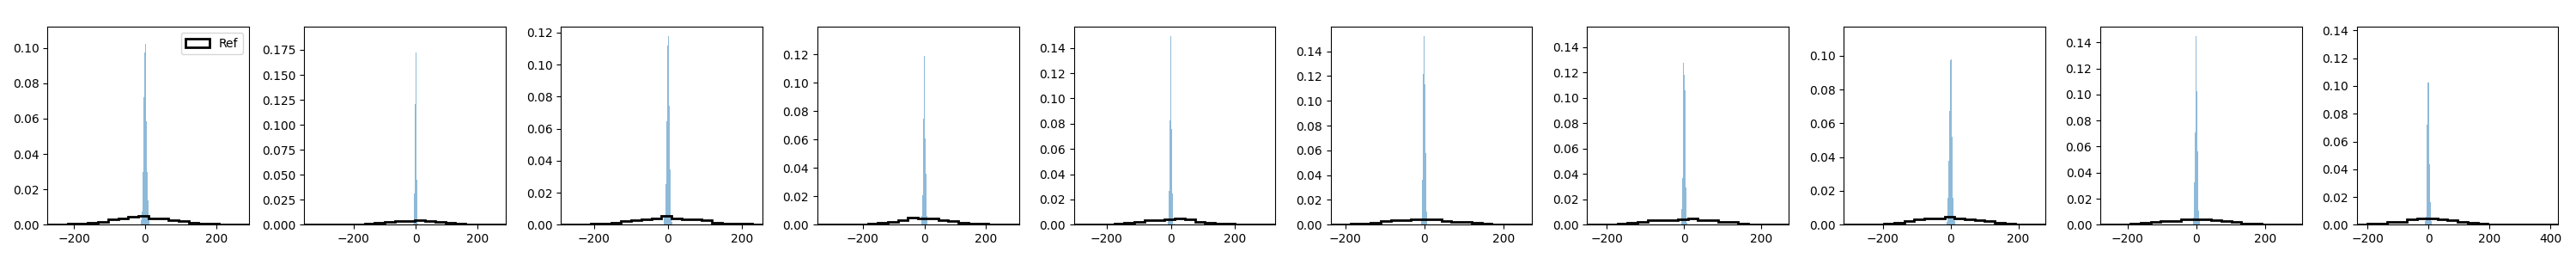

In [72]:
for D in [512, 1024, 2048, 4096, 8192]:
    print(D)
    display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg1.00/hist6000.png'))


[]

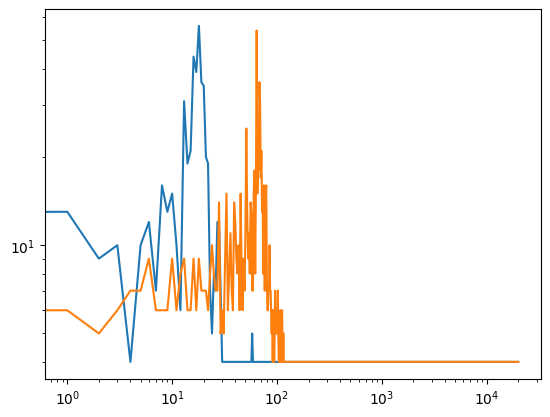

In [22]:
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond//R16-seed0/pbam/B2-reg10.00//nprojects.npy'))
plt.loglog()
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512//R16-seed0/pbam/B2-reg10.00//nprojects.npy'))
plt.loglog()